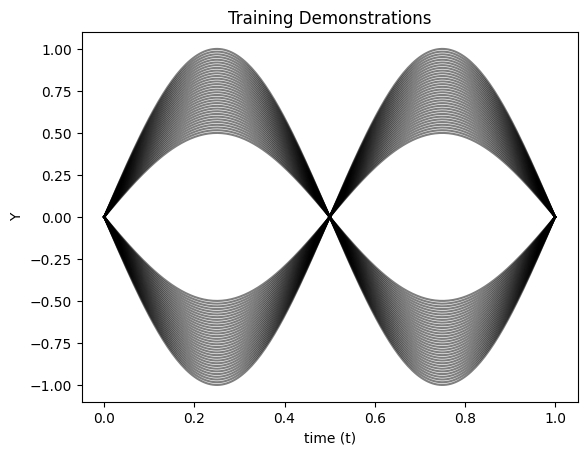

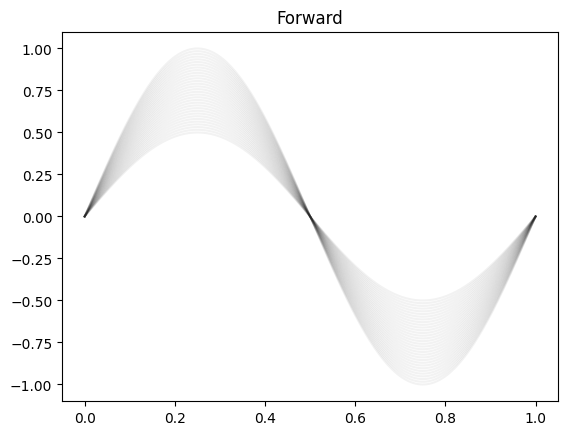

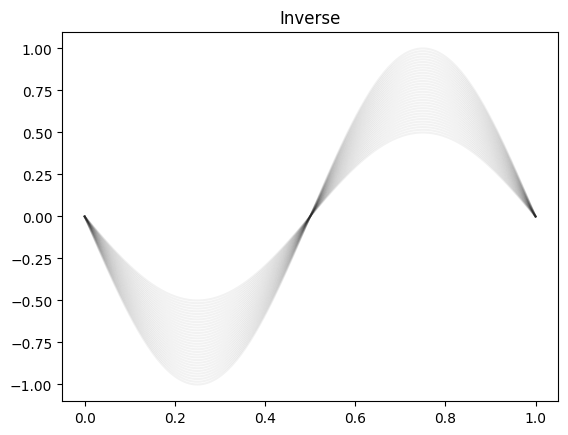

In [77]:
from cProfile import label
from re import X
from turtle import color
from sympy import li
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math
import importlib

import dual_enc_dec_cnmp
import utils
importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)

#params = np.array([[2,0],[2,0],[2,0],[2,0],[2,0],[-0.6,0.1],[-0.55, 0.16],[-0.5,0.23],[-0.45, 0.33],[-0.4,0.43]])
params = np.array([[20],[19.9],[19.7]])
validation_indices = [i+1 for i in range(0, 32, 8)]

X1, X2, Y1, Y2, validation_Y1, validation_Y2 = utils.generate_demonstrations(time_len=200, params = params, plot_title='Training')

In [93]:
import wandb
sweep_configuration = {
    "method": "random",
    "name": "sweep",
    "metric": {"goal": "minimize", "name": "val_error"},
    "parameters": {
        "epochs": {"min": 50000, "max": 500000},
        "lr": {"max": 1e-3, "min": 1e-7},
    },
}
sweep_id = wandb.sweep(sweep=sweep_configuration, project="inverse-CNMP-sweep")



Create sweep with ID: z6dwx95k
Sweep URL: https://wandb.ai/serdarbahar-bogazi-i-niversitesi/inverse-CNMP-sweep/sweeps/z6dwx95k


In [94]:
demo_data = [X1, X2, Y1, Y2]
d_x = 1
d_y1 = 1
d_y2 = 1
OBS_MAX = 5
d_N = Y1.shape[0]
time_len = 200
errors = []
losses = []

In [95]:
importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)

def train():

    run = wandb.init()

    model = dual_enc_dec_cnmp.DualEncoderDecoder(d_x, d_y1, d_y2).double()

    EPOCHS = wandb.config.epochs
    learning_rate = wandb.config.lr

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50000, gamma=0.1)

    for i in range(EPOCHS):

        obs, x_tar, y_tar = dual_enc_dec_cnmp.get_training_sample(validation_indices, X1, Y1, X2, Y2, OBS_MAX, d_N, d_x, d_y1, d_y2, time_len)
        optimizer.zero_grad()
        output = model(obs, x_tar)
        loss = dual_enc_dec_cnmp.log_prob_loss(output, y_tar, d_y1)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        
        if i % 100 == 0:
            if i % 1000 == 0:
                
                print(f'Epoch: {i}, Loss: {loss.item()}')
                error = 0
                for validation_idx in validation_indices:
                    time = np.linspace(0, 1, time_len)
                    # permute time
                    idx = np.random.permutation(time_len)
                    idx = idx[0]
                    time = time[idx]
                    condition_points = [[time, Y1[validation_idx, idx:idx+1]]]
                    means, stds = dual_enc_dec_cnmp.predict_inverse(model, validation_idx, time_len, condition_points, d_x, d_y1, d_y2, demo_data)
                    if i % 10000 == 0 and validation_idx == validation_indices[0]:
                        error += utils.validate_model(means, stds, validation_idx, demo_data, time_len, condition_points, i, plot=False)
                    else:
                        error += utils.validate_model(means, stds, validation_idx, demo_data, time_len, condition_points, i, plot=False)
                errors.append(error)
                if error == min(errors):
                    print('Saving model ', i)
                    torch.save(model.state_dict(), 'inverse_best_model.pth')
                
                
                losses.append(loss.item())
                """
                if loss.item() == min(losses):
                    print('Saving model ', i)
                    torch.save(model.state_dict(), 'inverse_best_model.pth')
                """
                
                continue

            losses.append(loss.item())
            
            """
            if loss.item() == min(losses):
                print('Saving model ', i)
                torch.save(model.state_dict(), 'inverse_best_model.pth')
            """
        
        
        val_error = errors[-1]
        
        wandb.log(
                {
                    "epoch": i,
                    "val_error": errors[-1],
                }
            )
    

In [96]:
wandb.agent(sweep_id, function=train, count=5)

wandb: Agent Starting Run: xoty3905 with config:
wandb: 	epochs: 197927
wandb: 	lr: 0.00010320177326578638


Epoch: 0, Loss: 0.675838880907221
Saving model  0


/Users/serdarbahar/Desktop/cnmp/inverse_task/utils.py:128: UserWarning: Using a target size (torch.Size([1, 200])) that is different to the input size (torch.Size([200])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  error = torch.mean(torch.nn.functional.mse_loss(means, target_demo))


Epoch: 1000, Loss: 0.24845232576044562
Saving model  1000
Epoch: 2000, Loss: 0.44730833665398917
Saving model  2000
Epoch: 3000, Loss: 0.43161293415023205
Saving model  3000
Epoch: 4000, Loss: 0.6216428216941698
Saving model  4000
Epoch: 5000, Loss: -0.21188039426776295
Saving model  5000
Epoch: 6000, Loss: -0.09081471400871144
Saving model  6000
Epoch: 7000, Loss: -0.07877185933338837
Saving model  7000
Epoch: 8000, Loss: -0.011370931576861532
Saving model  8000
Epoch: 9000, Loss: 0.5552502424759972
Epoch: 10000, Loss: 0.20013638641191034
Saving model  10000
Epoch: 11000, Loss: -0.48163285735056105
Saving model  11000
Epoch: 12000, Loss: -0.6750139065512435
Saving model  12000
Epoch: 13000, Loss: -0.9173806569692378
Saving model  13000
Epoch: 14000, Loss: -0.8136065918555317
Saving model  14000
Epoch: 15000, Loss: -0.7384823572301473
Saving model  15000
Epoch: 16000, Loss: -1.2817005085423512
Epoch: 17000, Loss: -1.185228913742792
Saving model  17000
Epoch: 18000, Loss: 0.521216995071

wandb: Ctrl + C detected. Stopping sweep.


Epoch: 105000, Loss: -1.6423722847045652


/var/folders/63/kw9gvntx3hzftcn6fp7wkf0c0000gn/T/ipykernel_27593/3247921439.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('invers

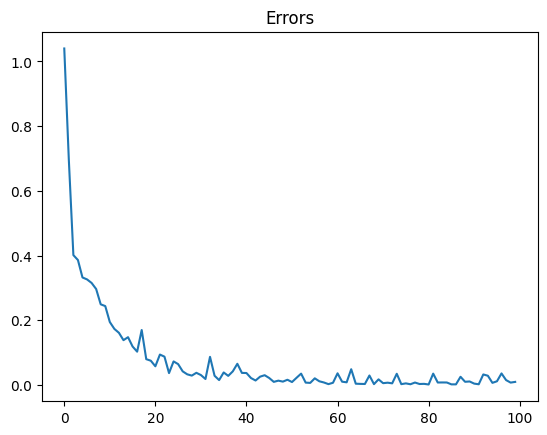

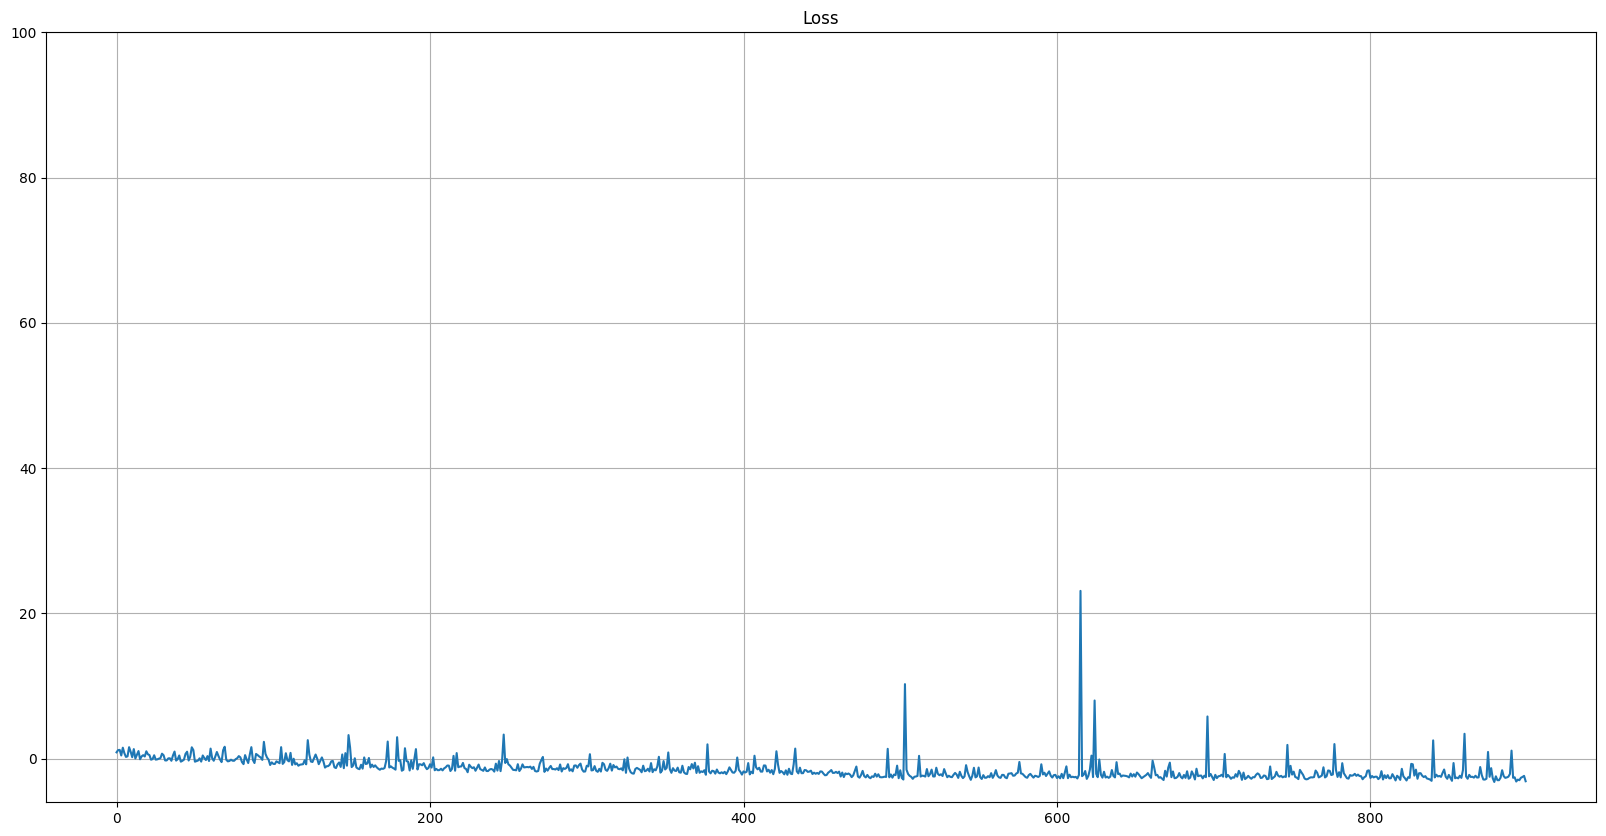

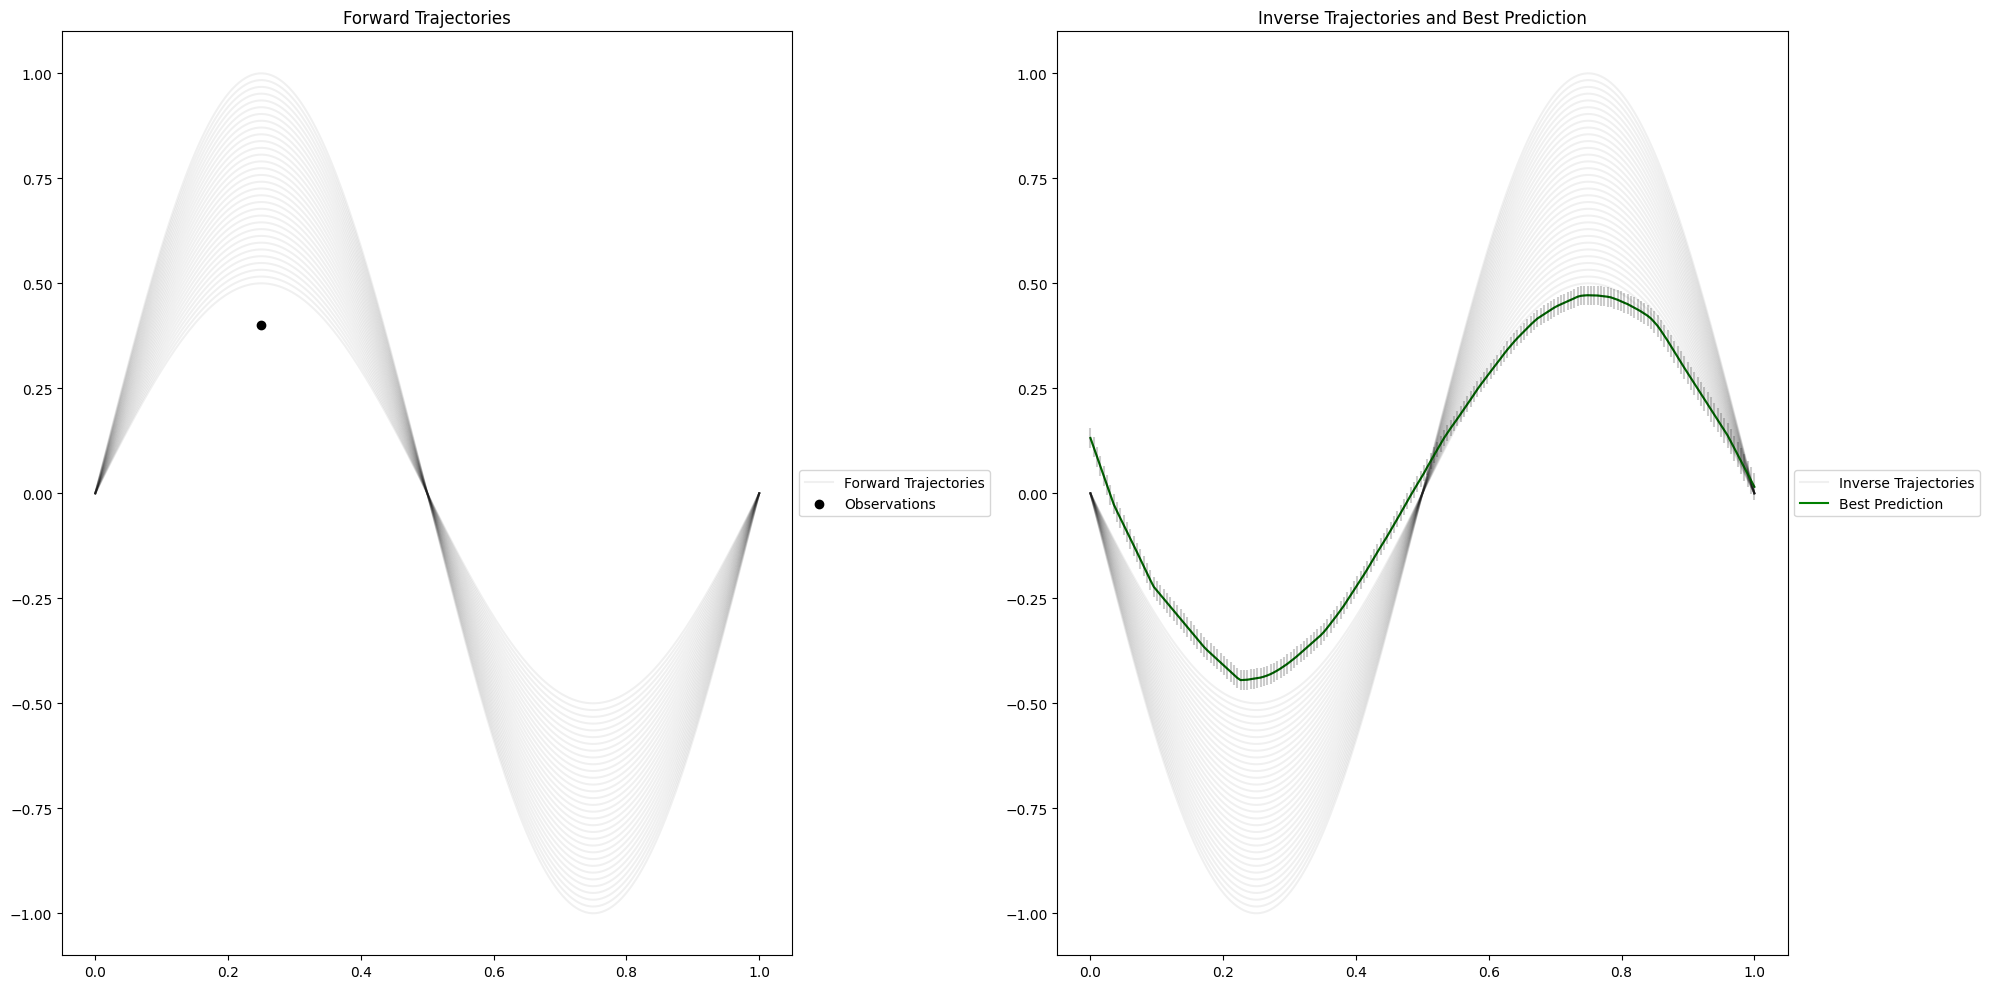

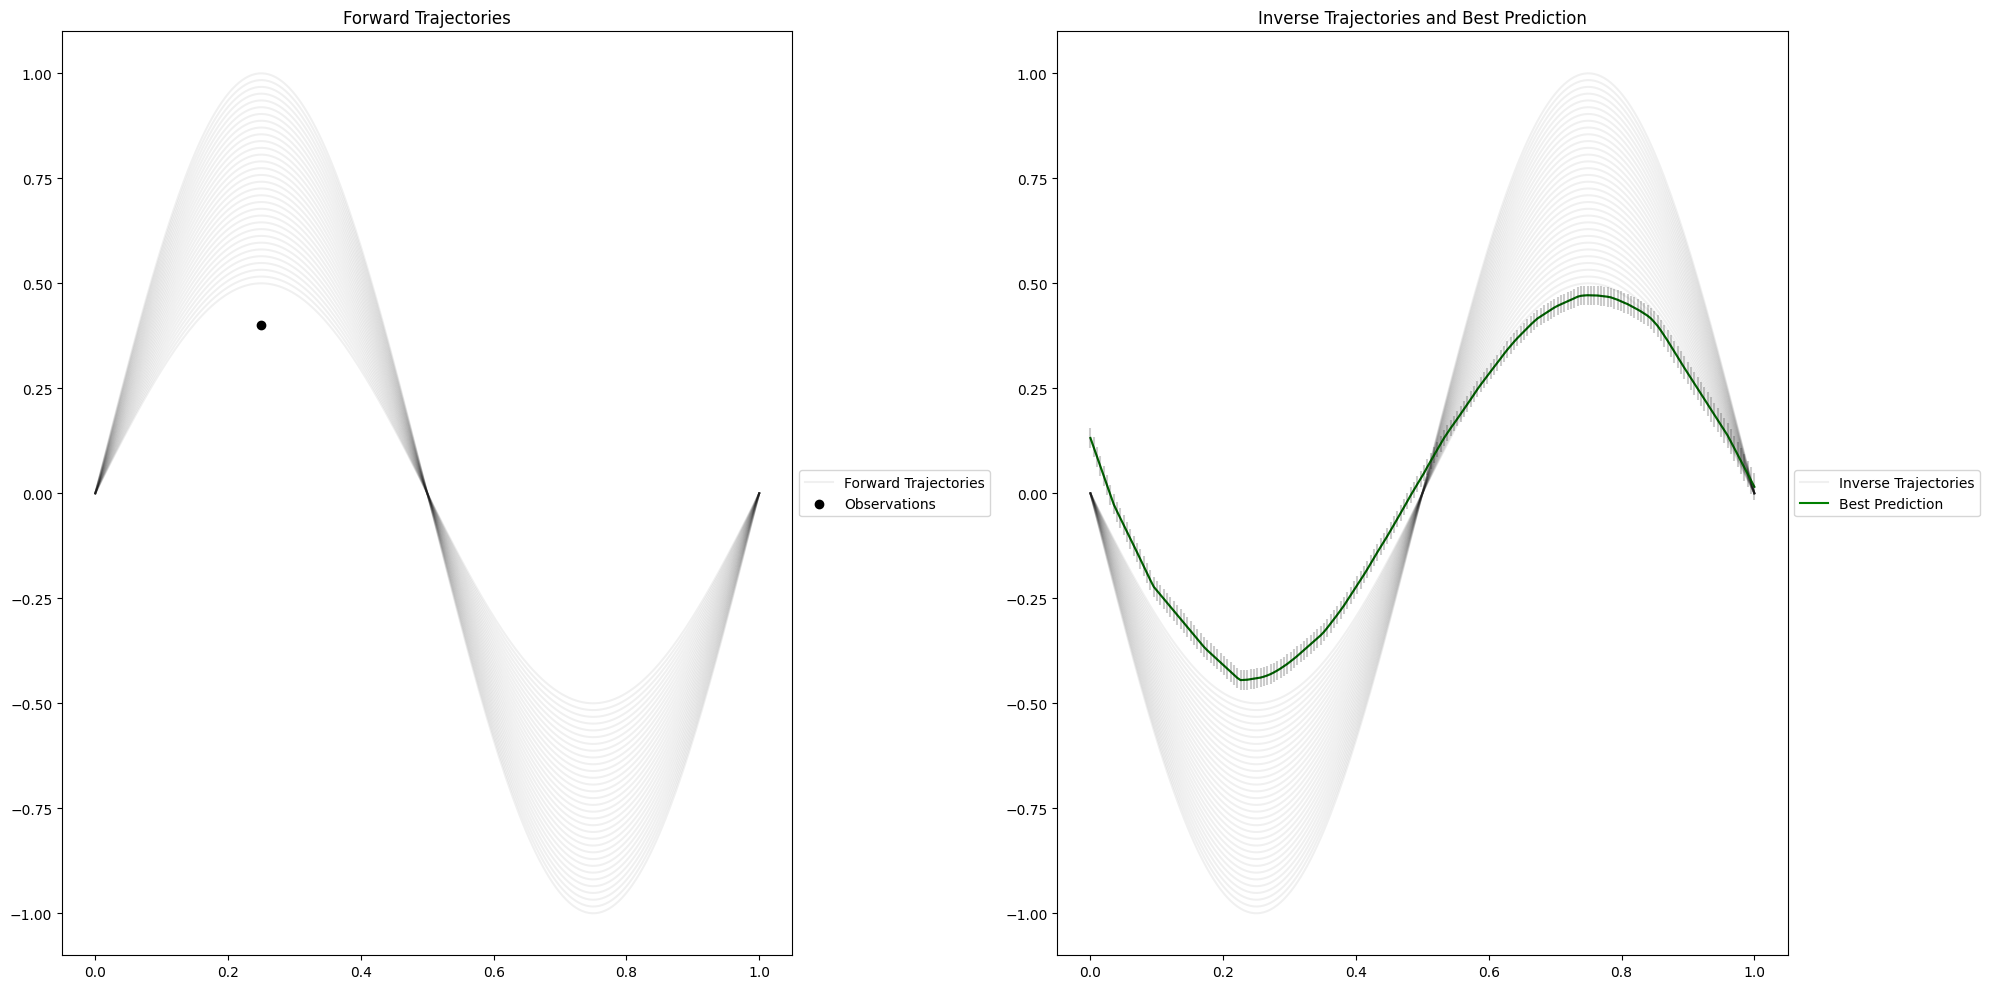

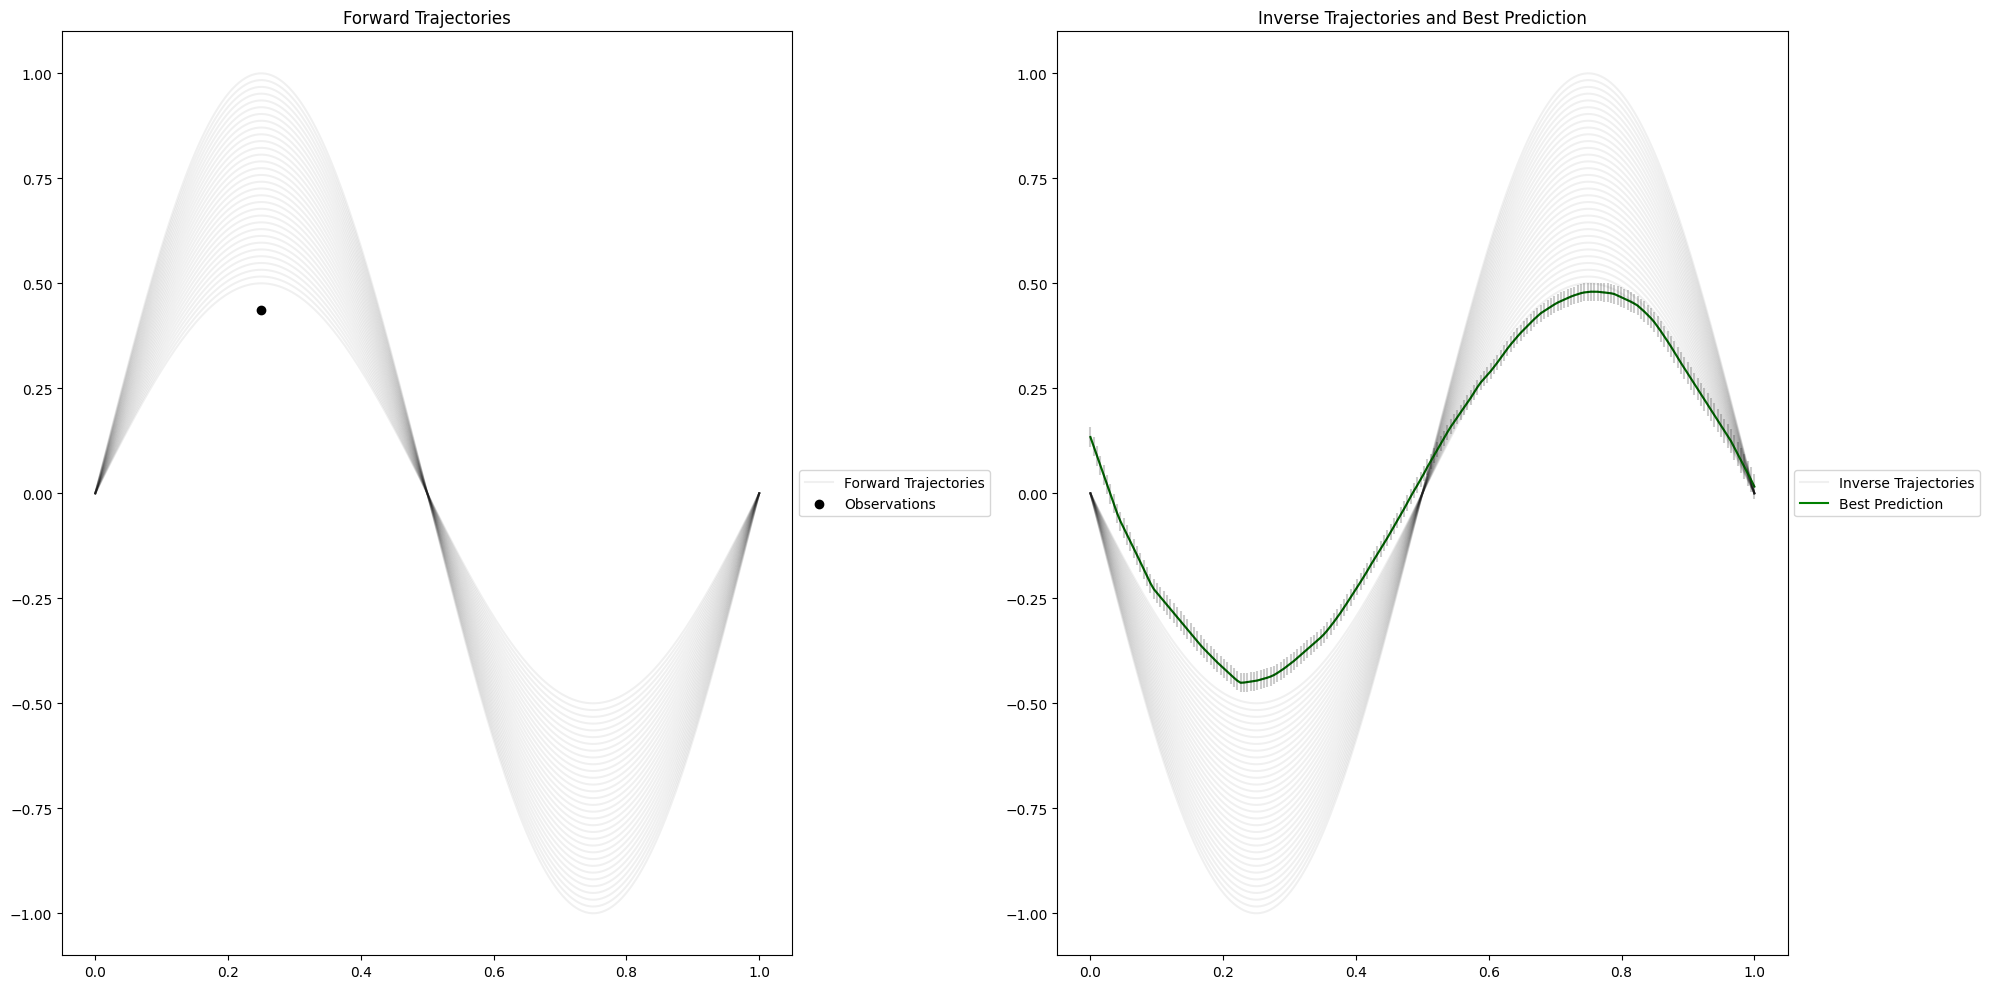

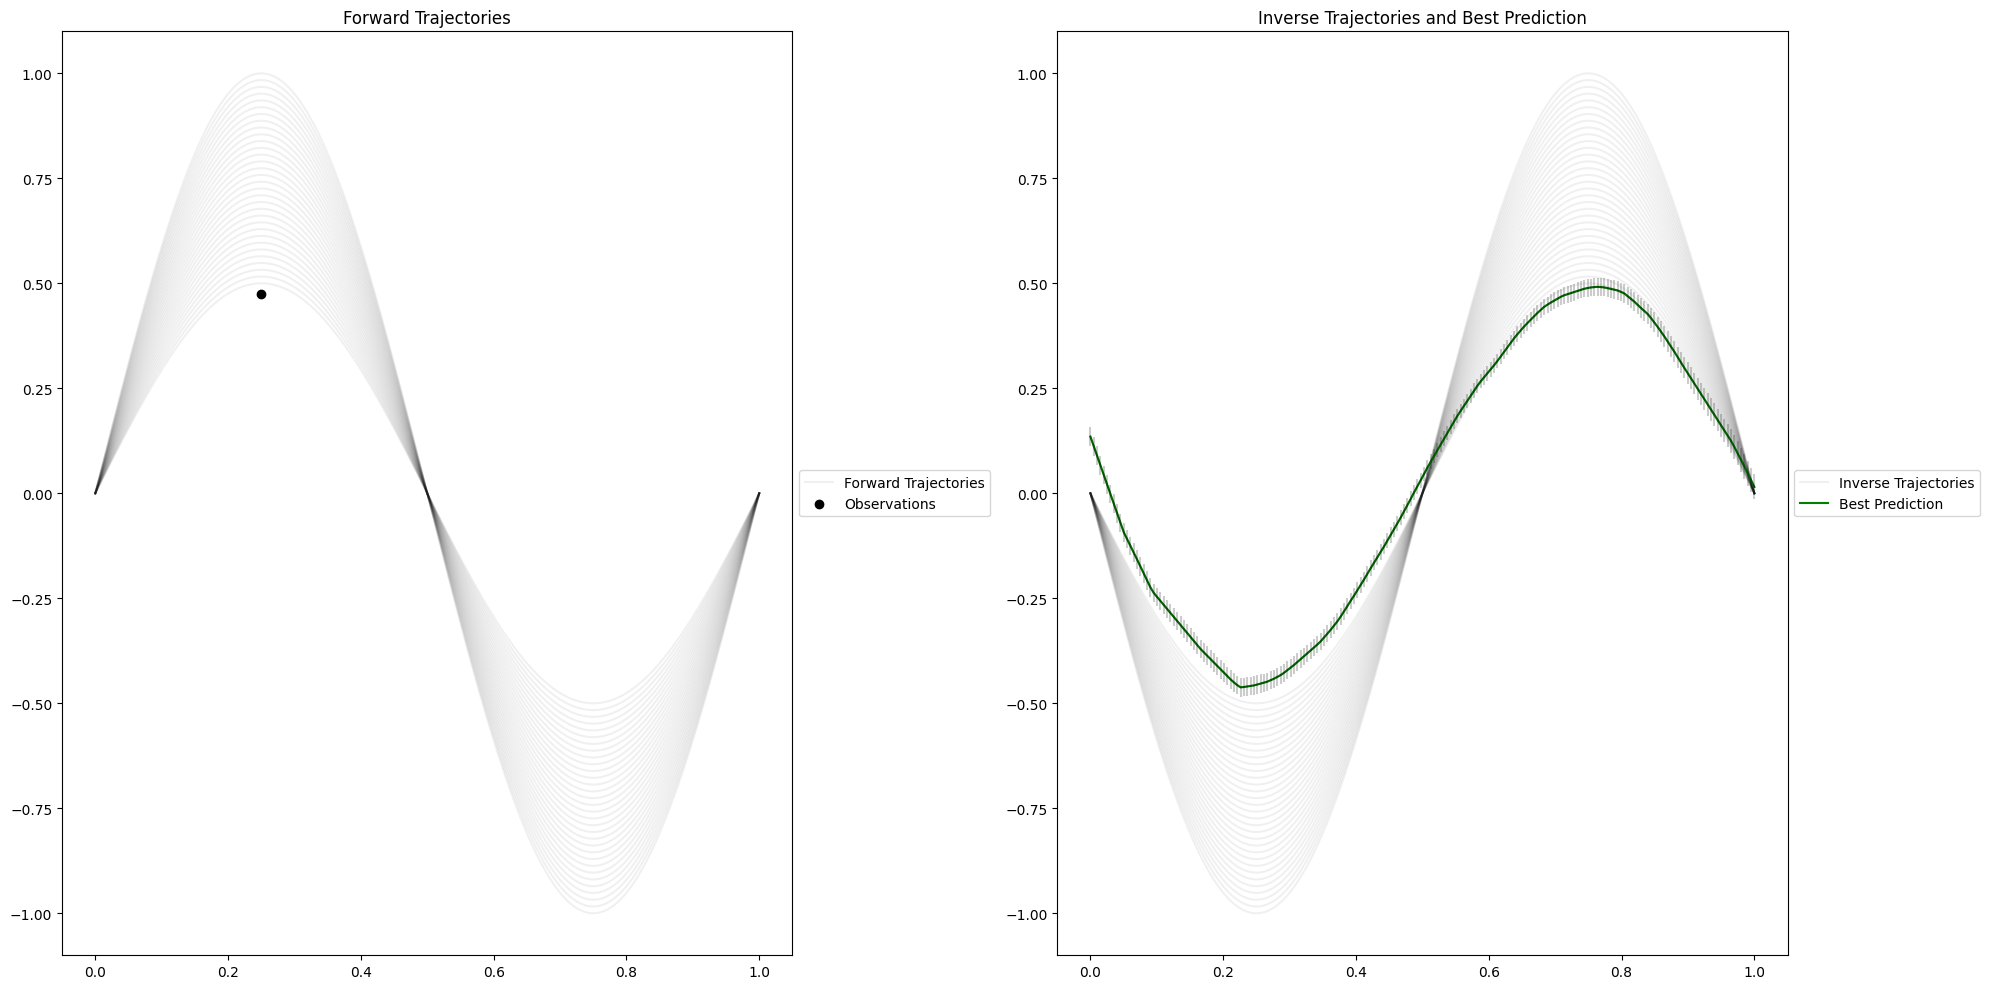

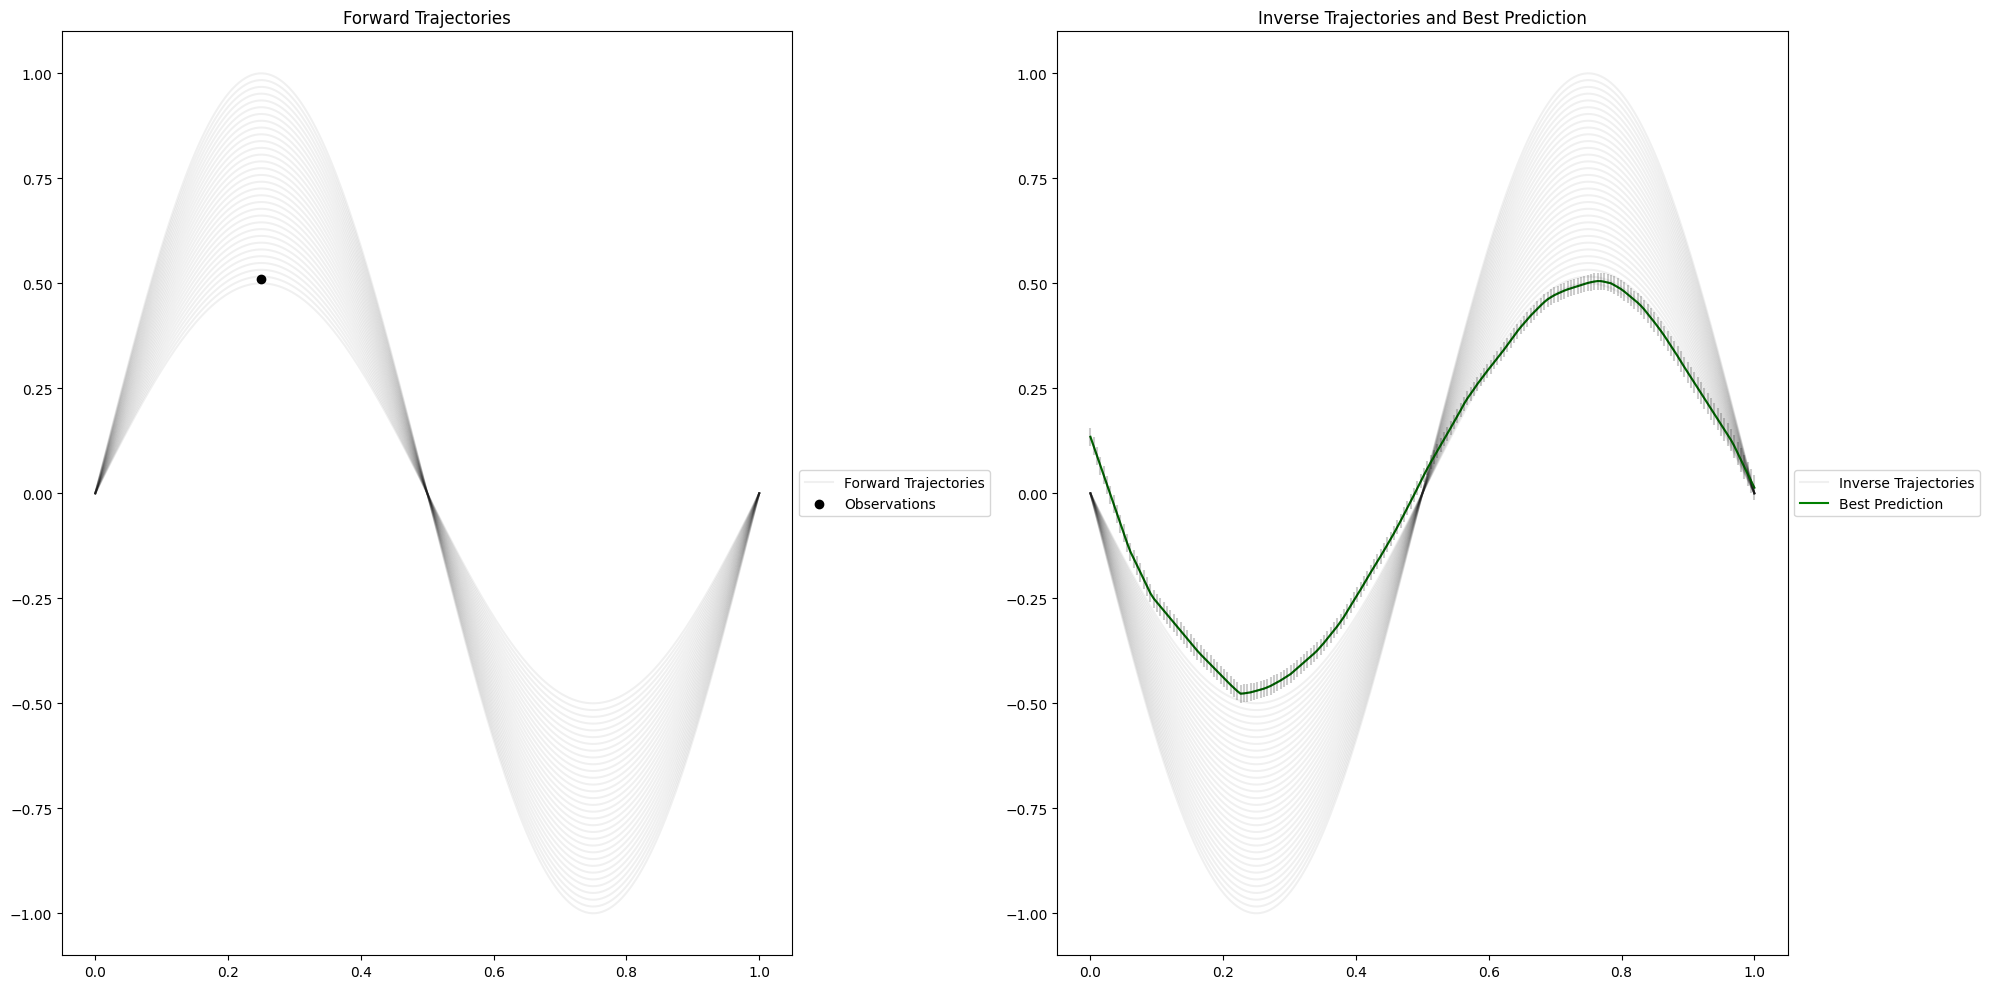

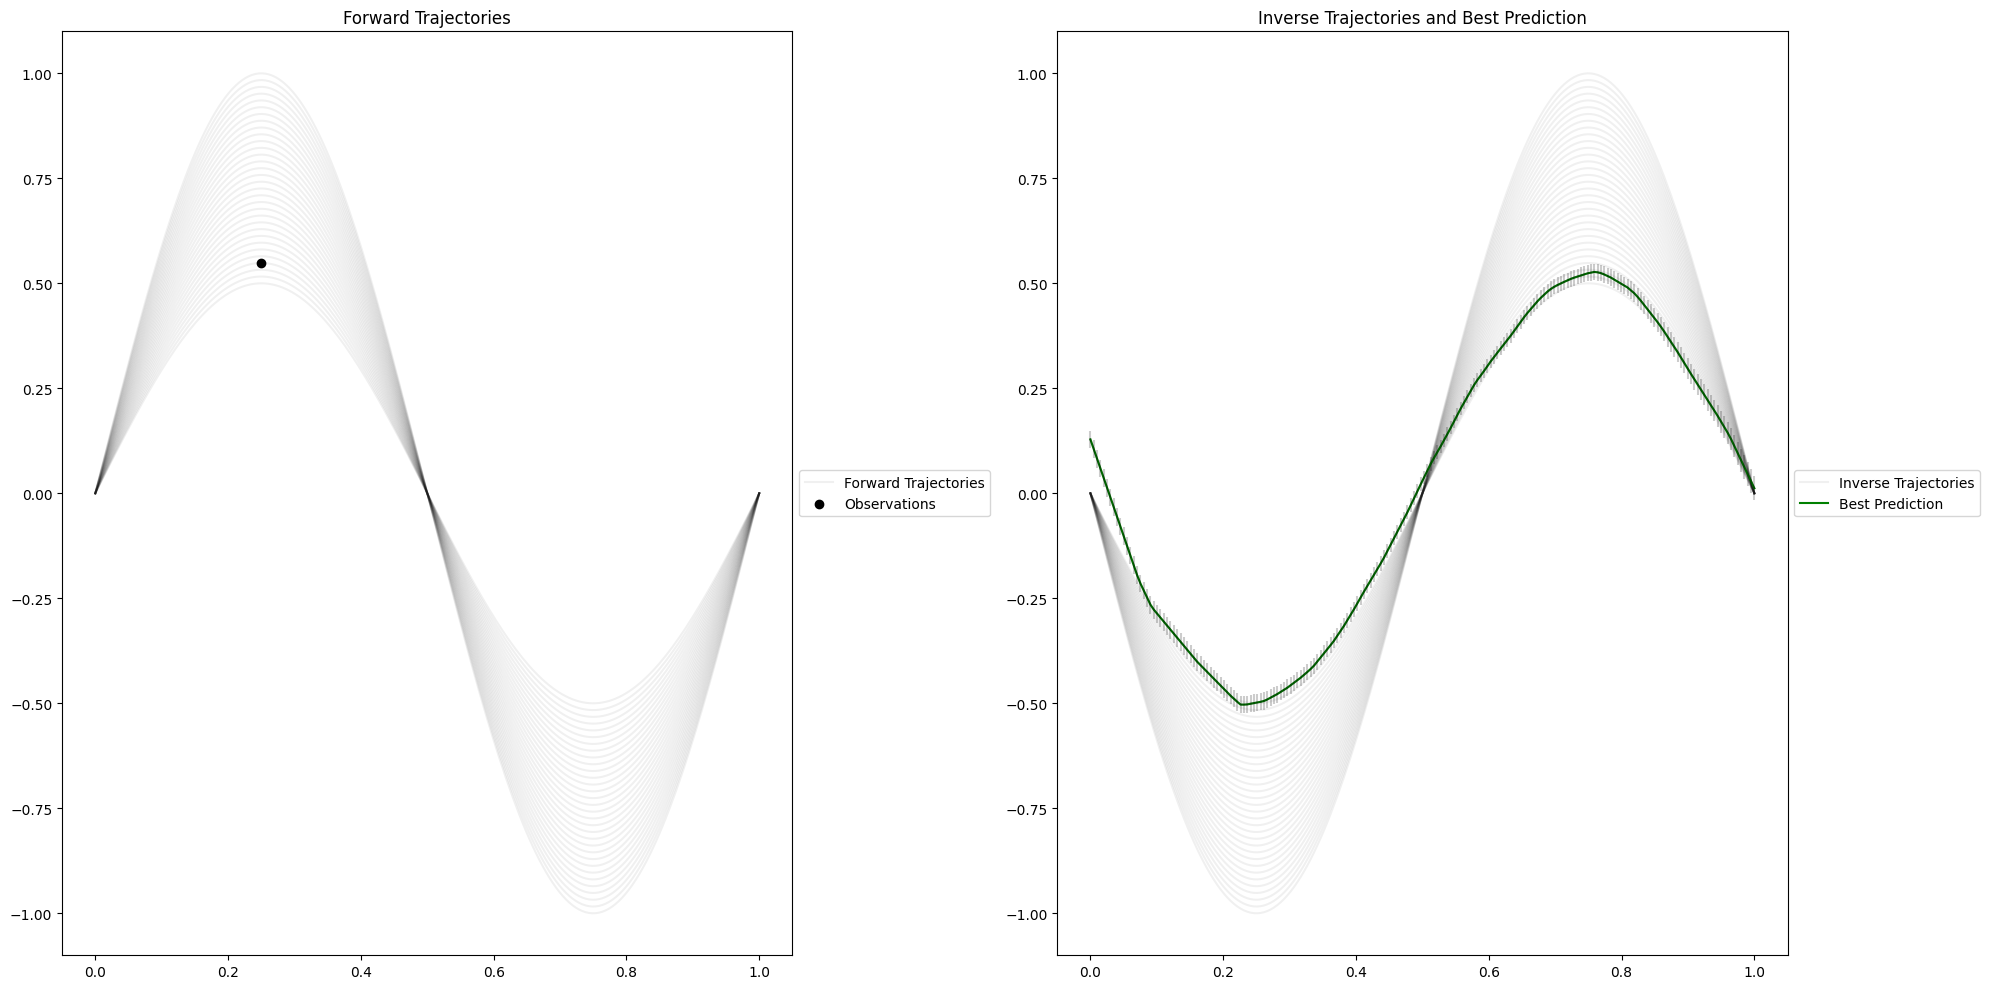

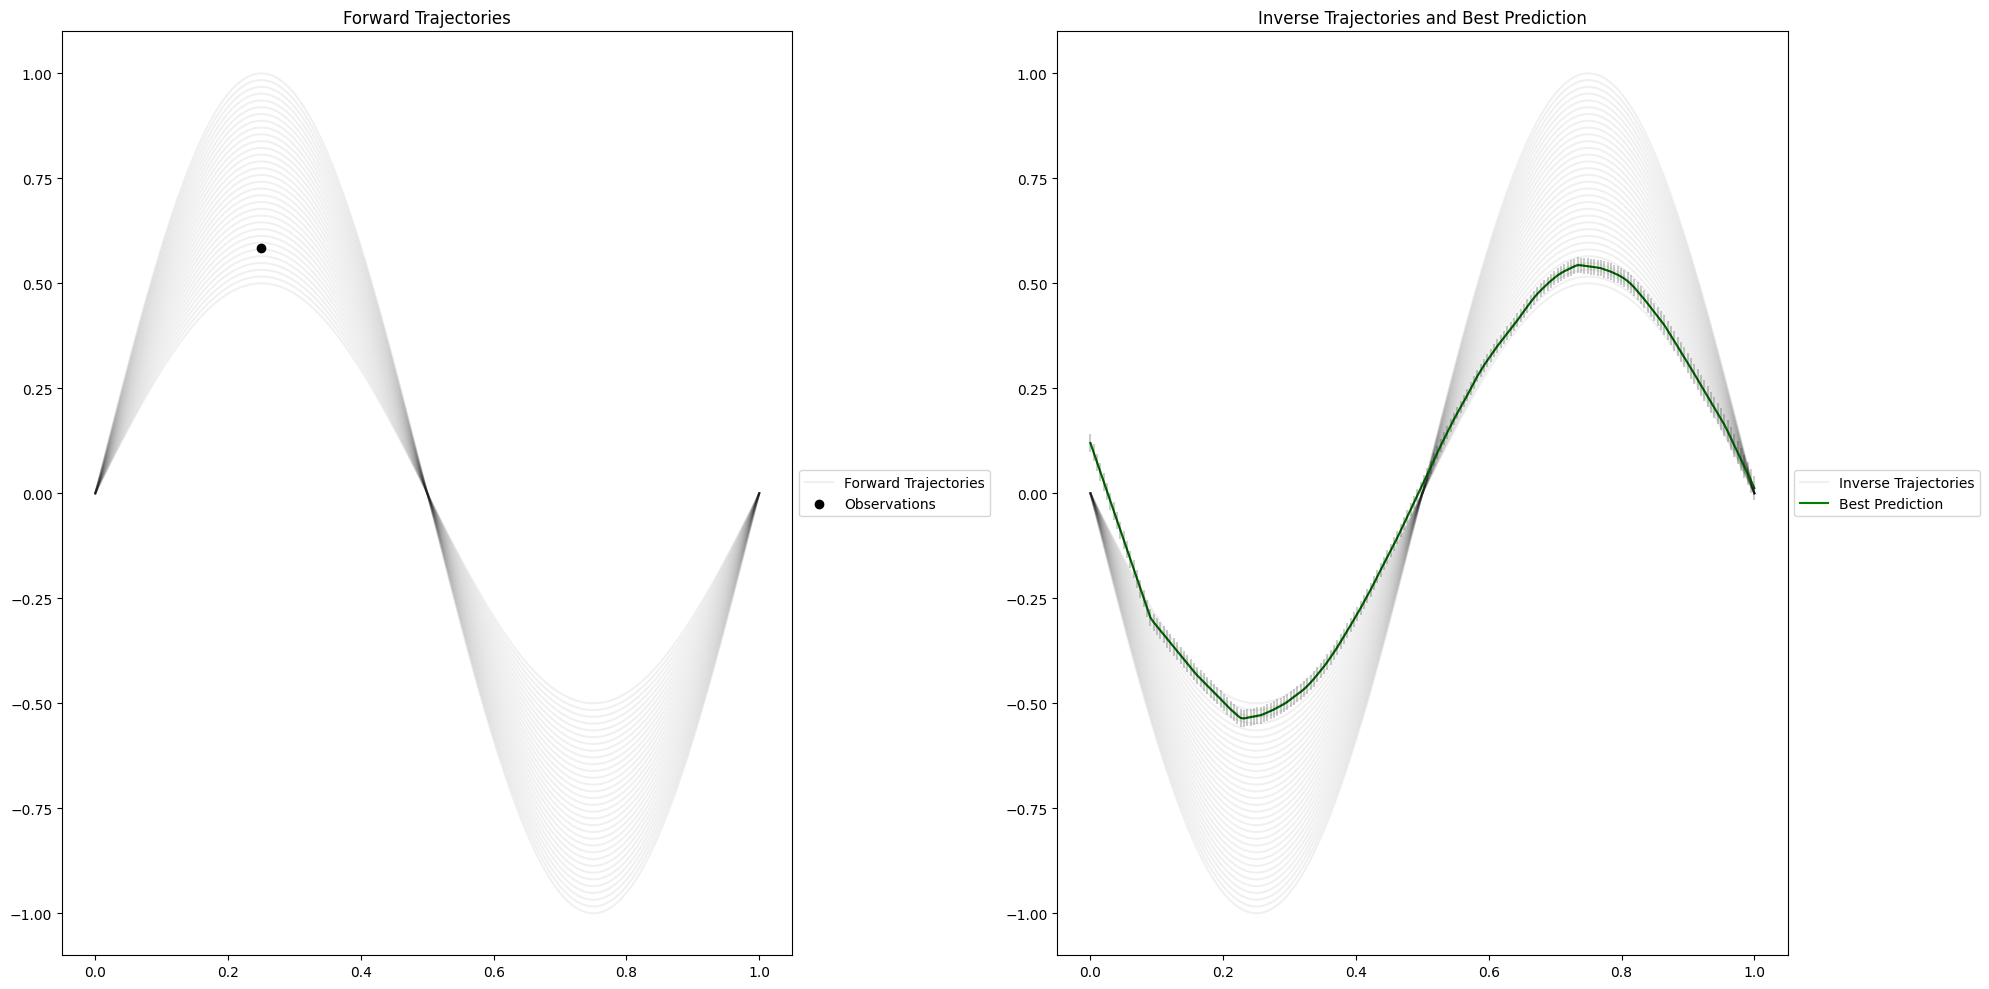

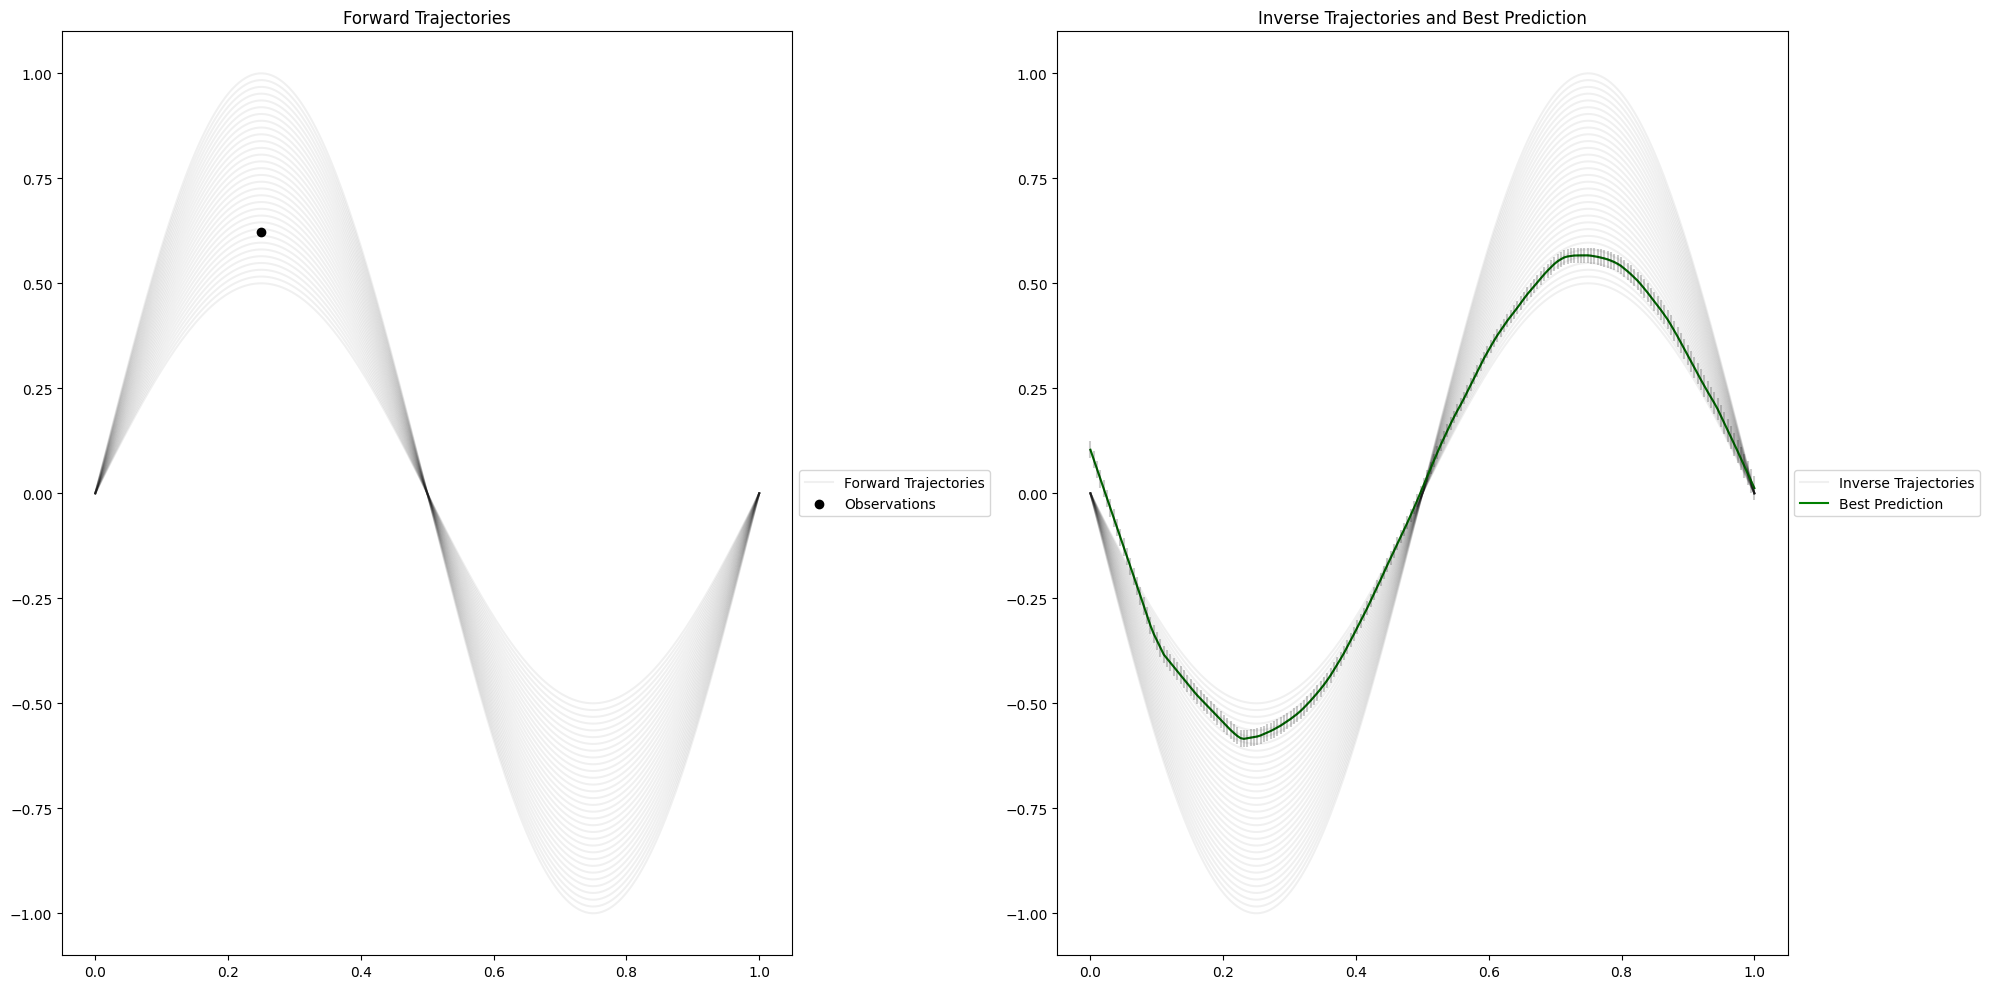

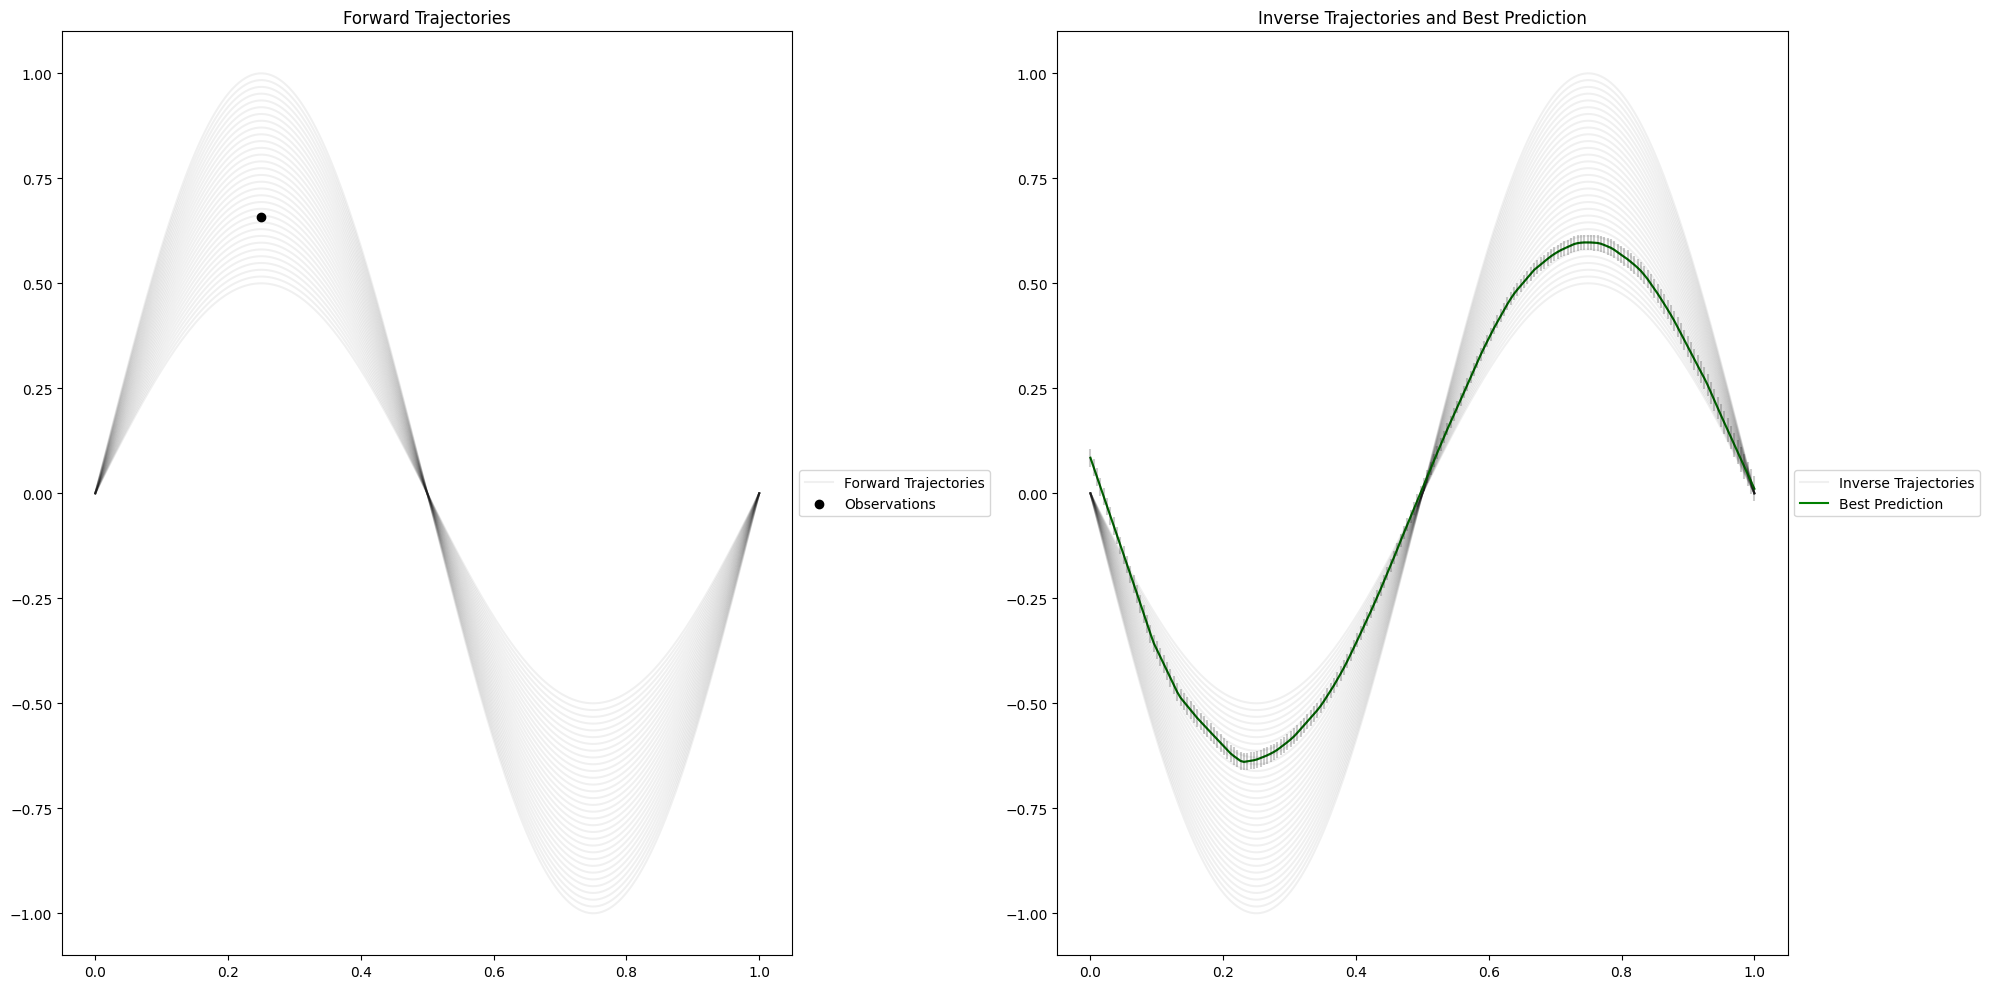

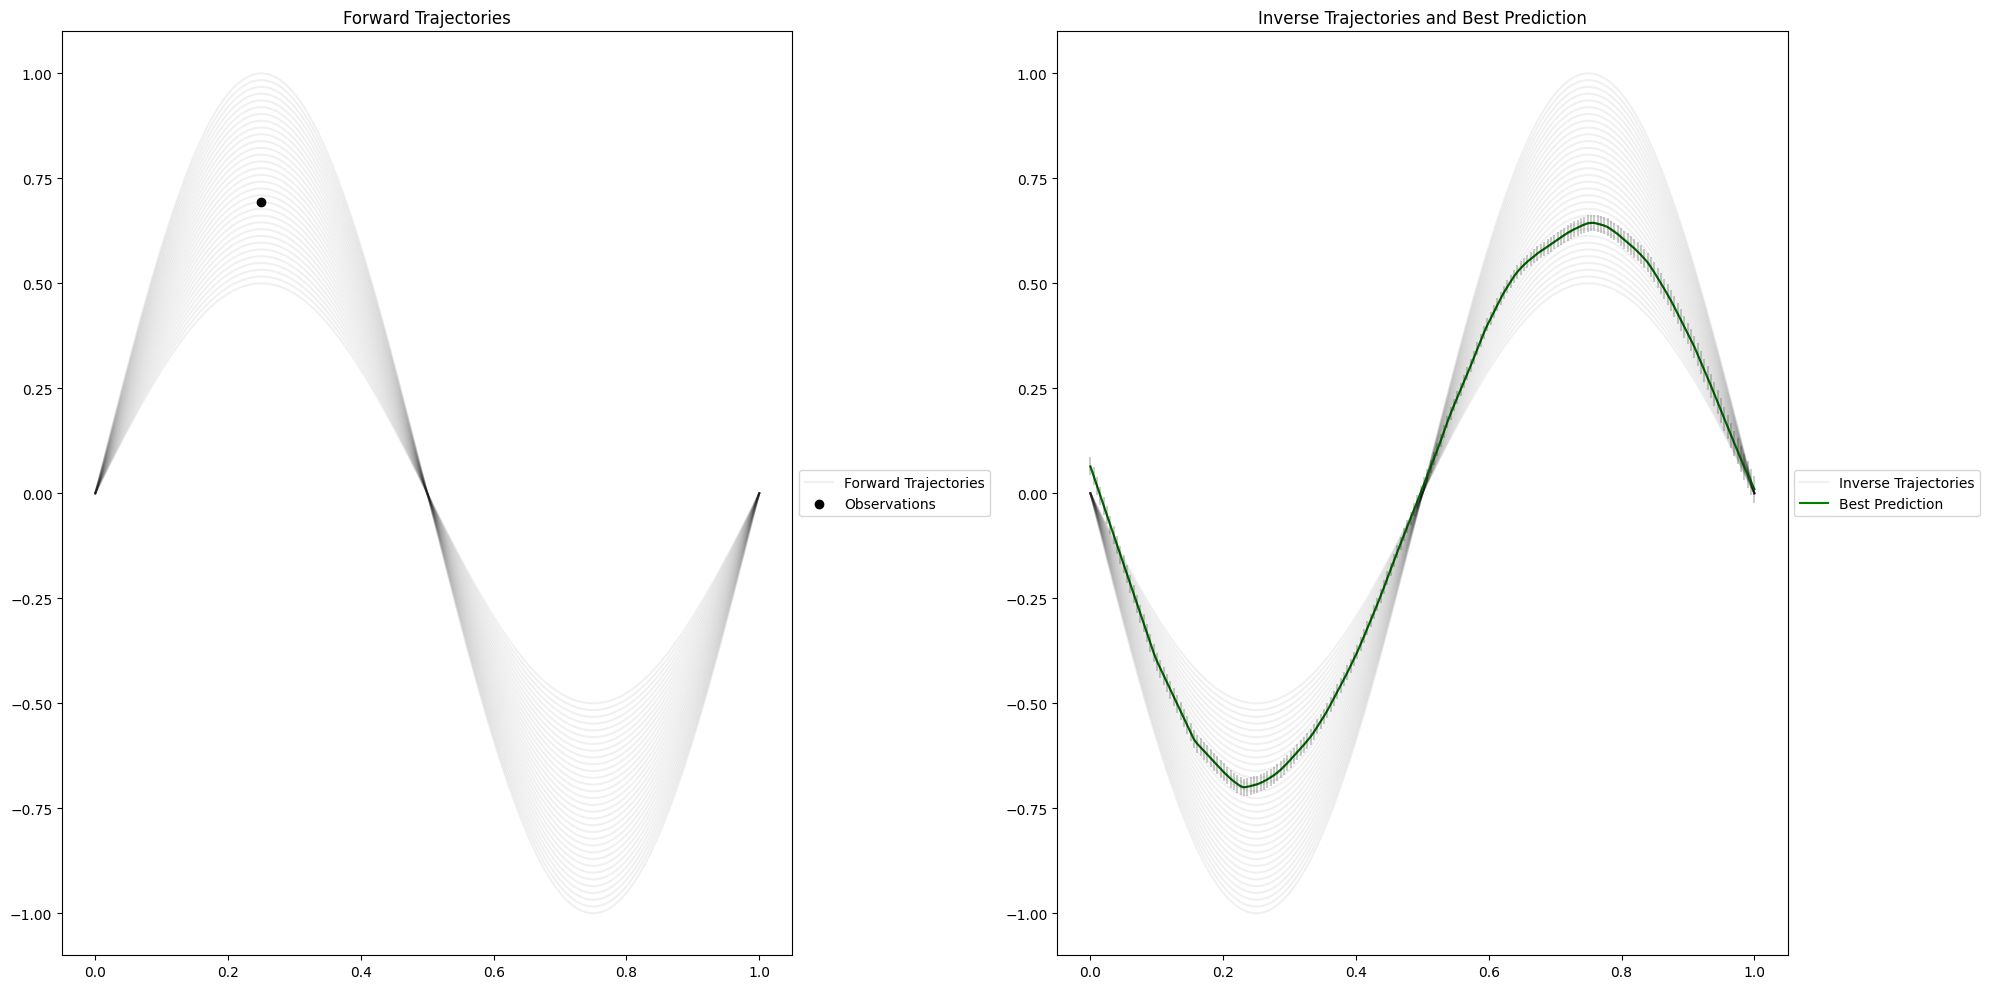

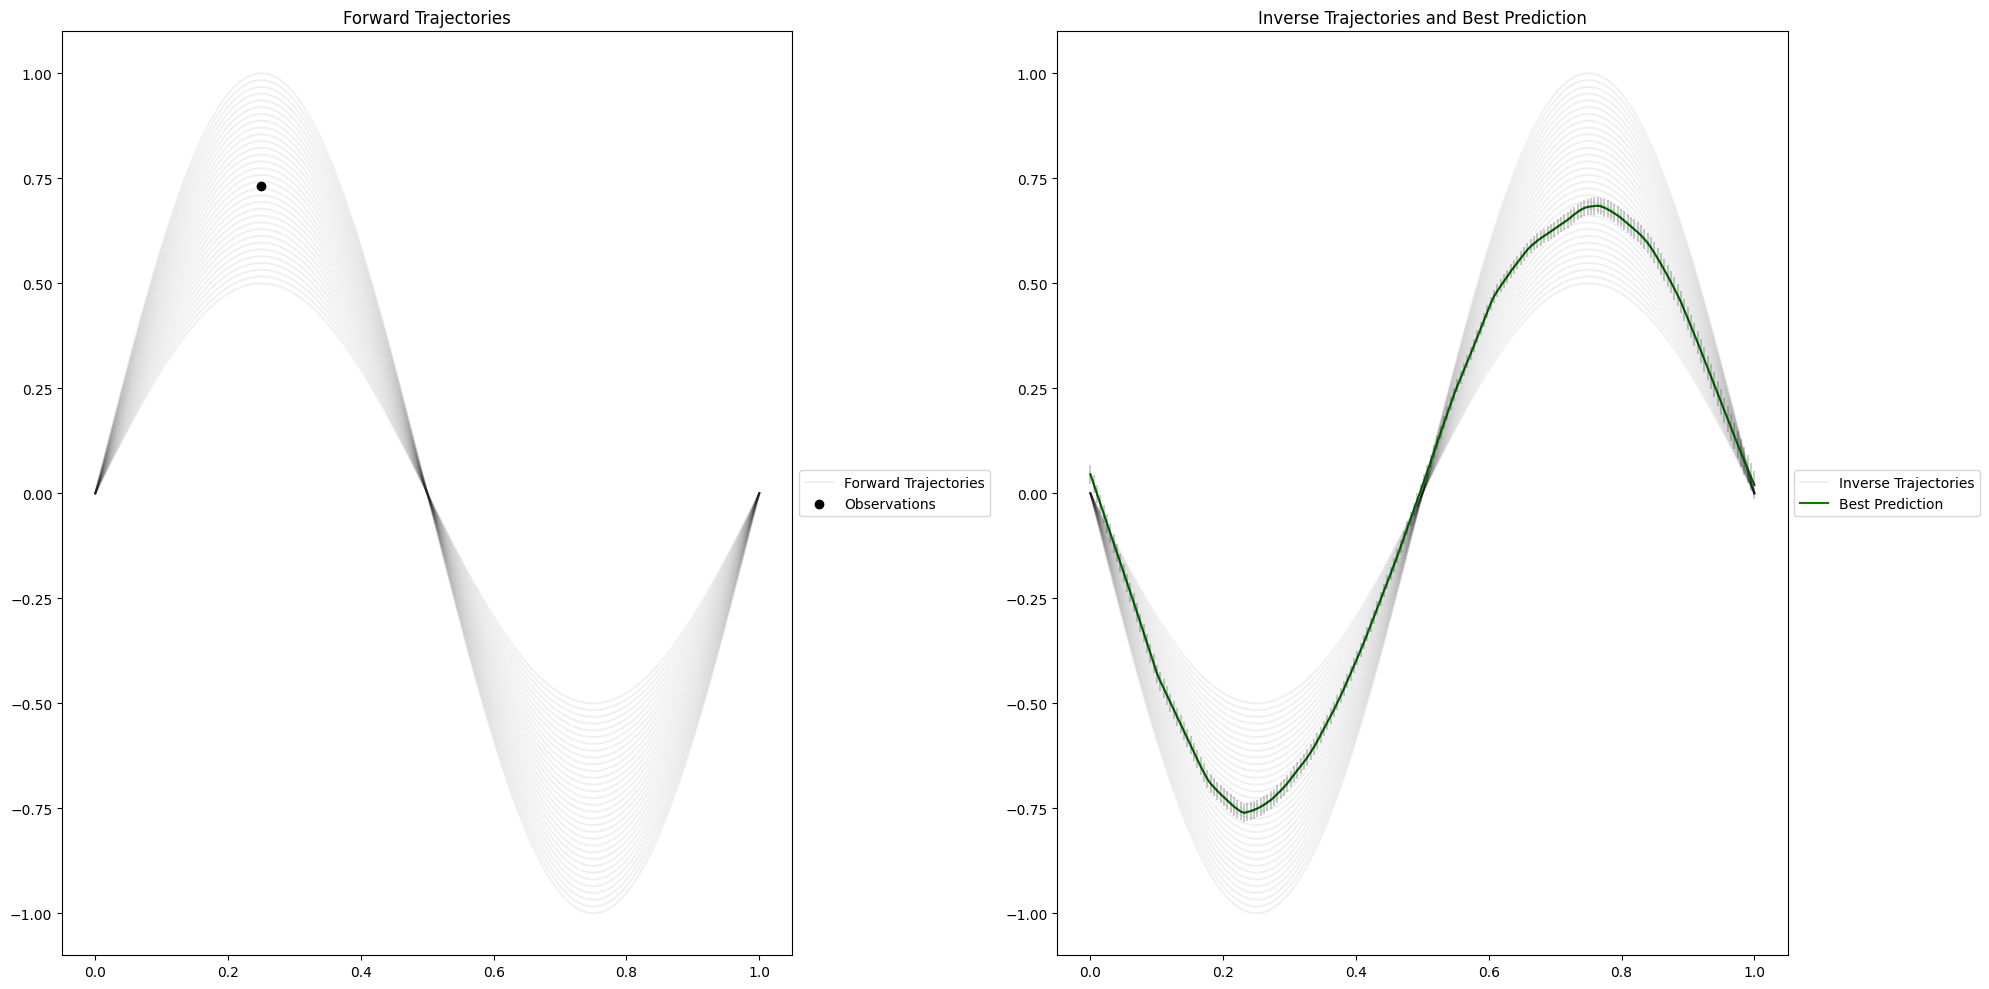

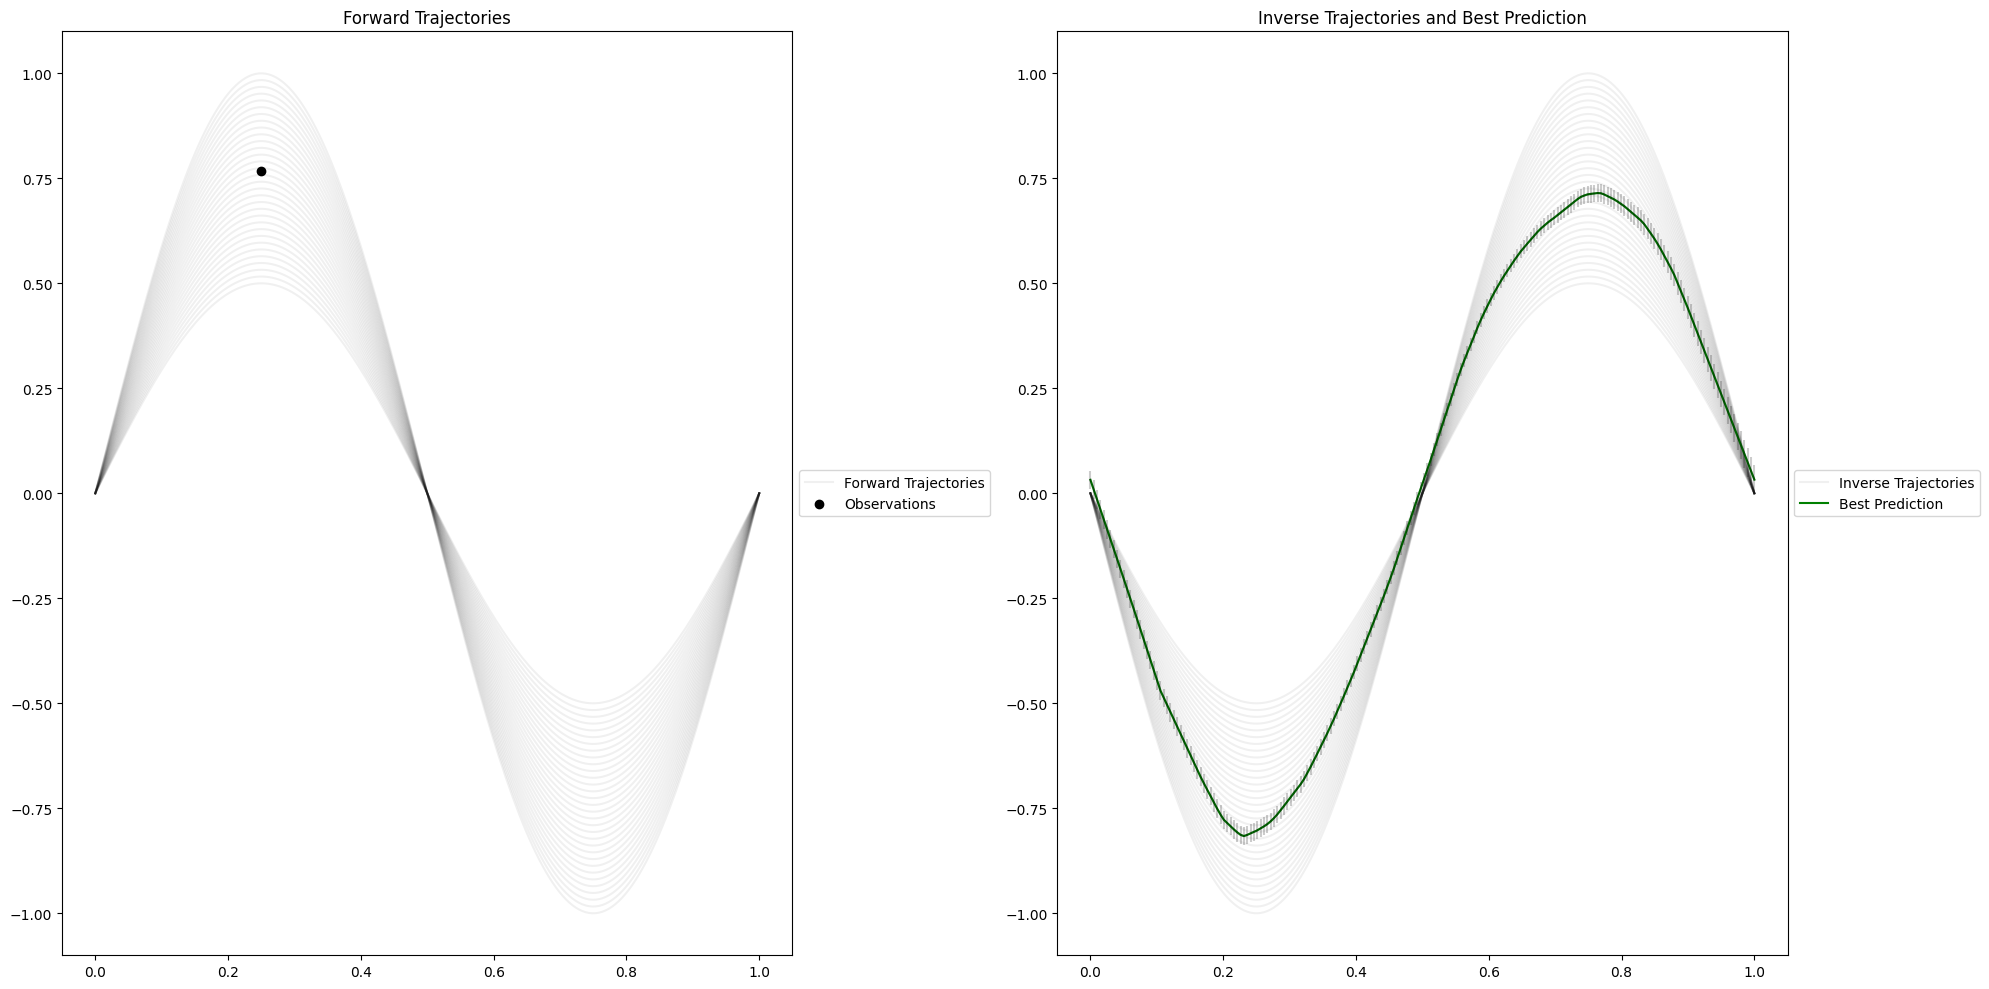

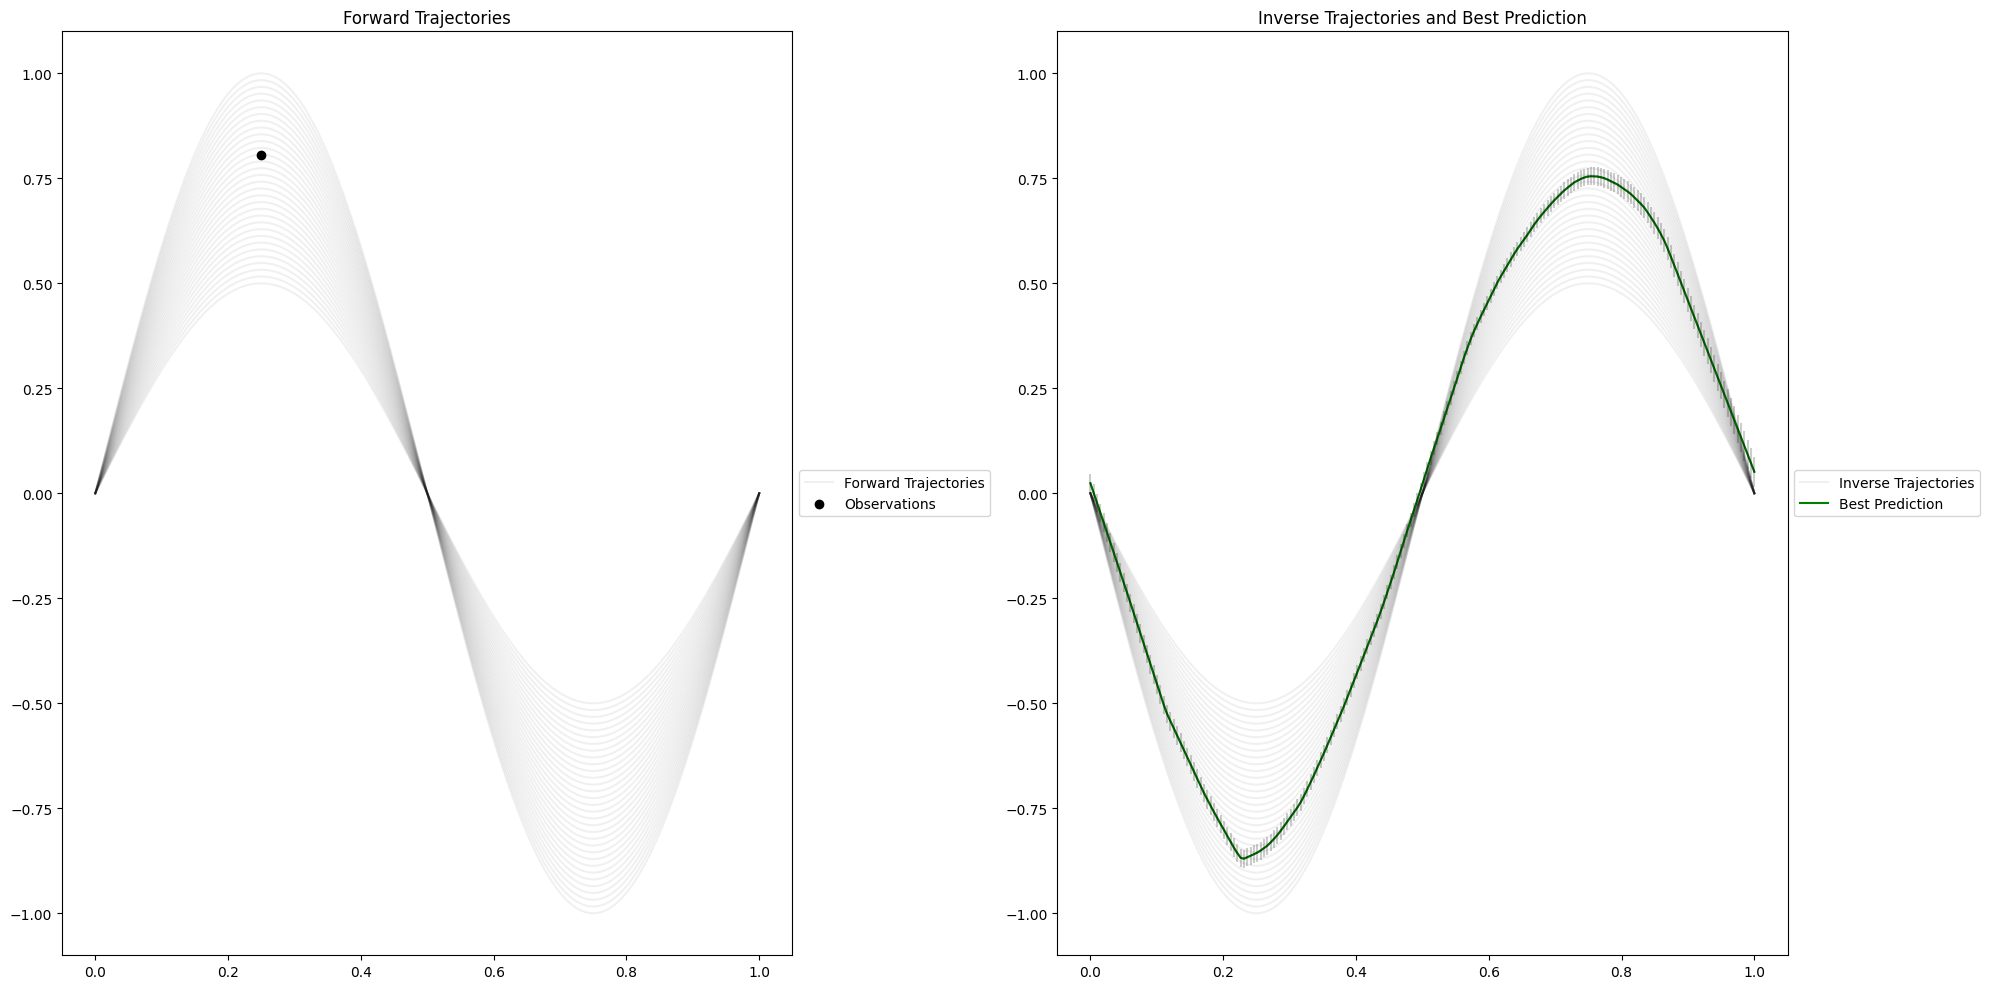

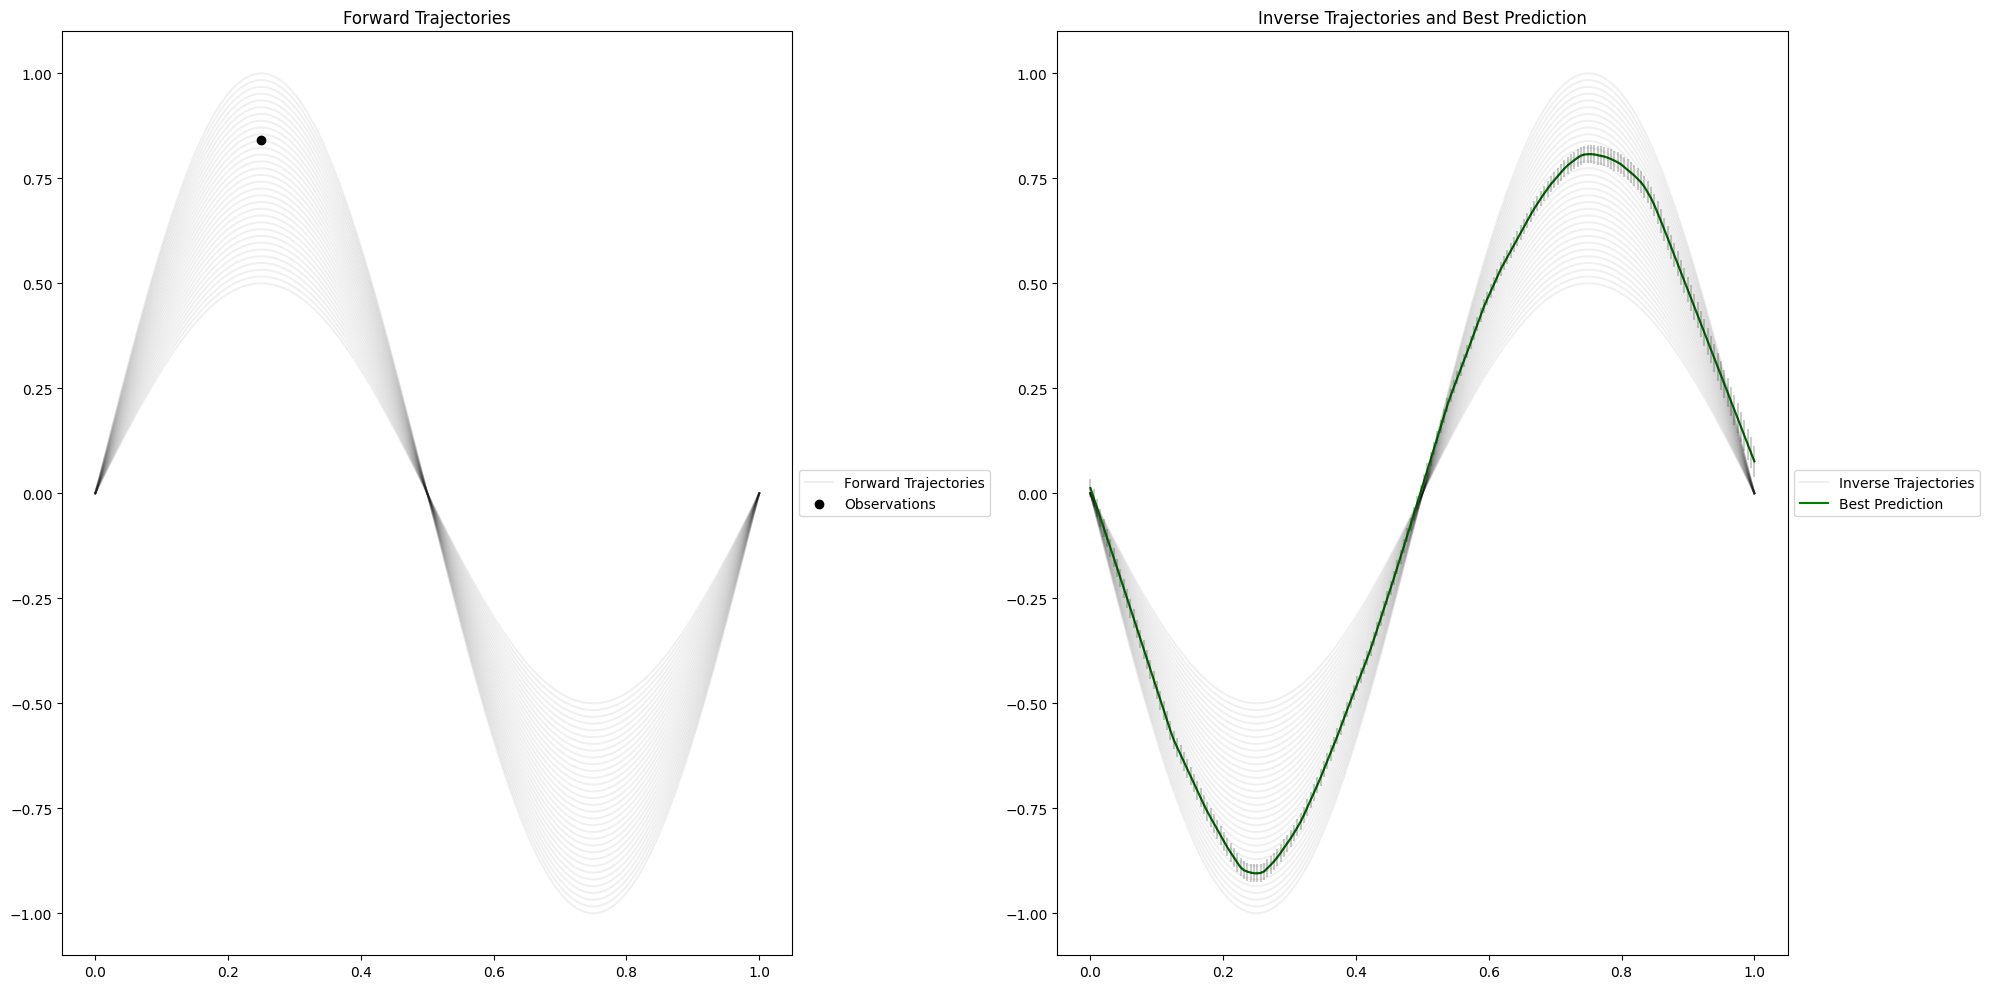

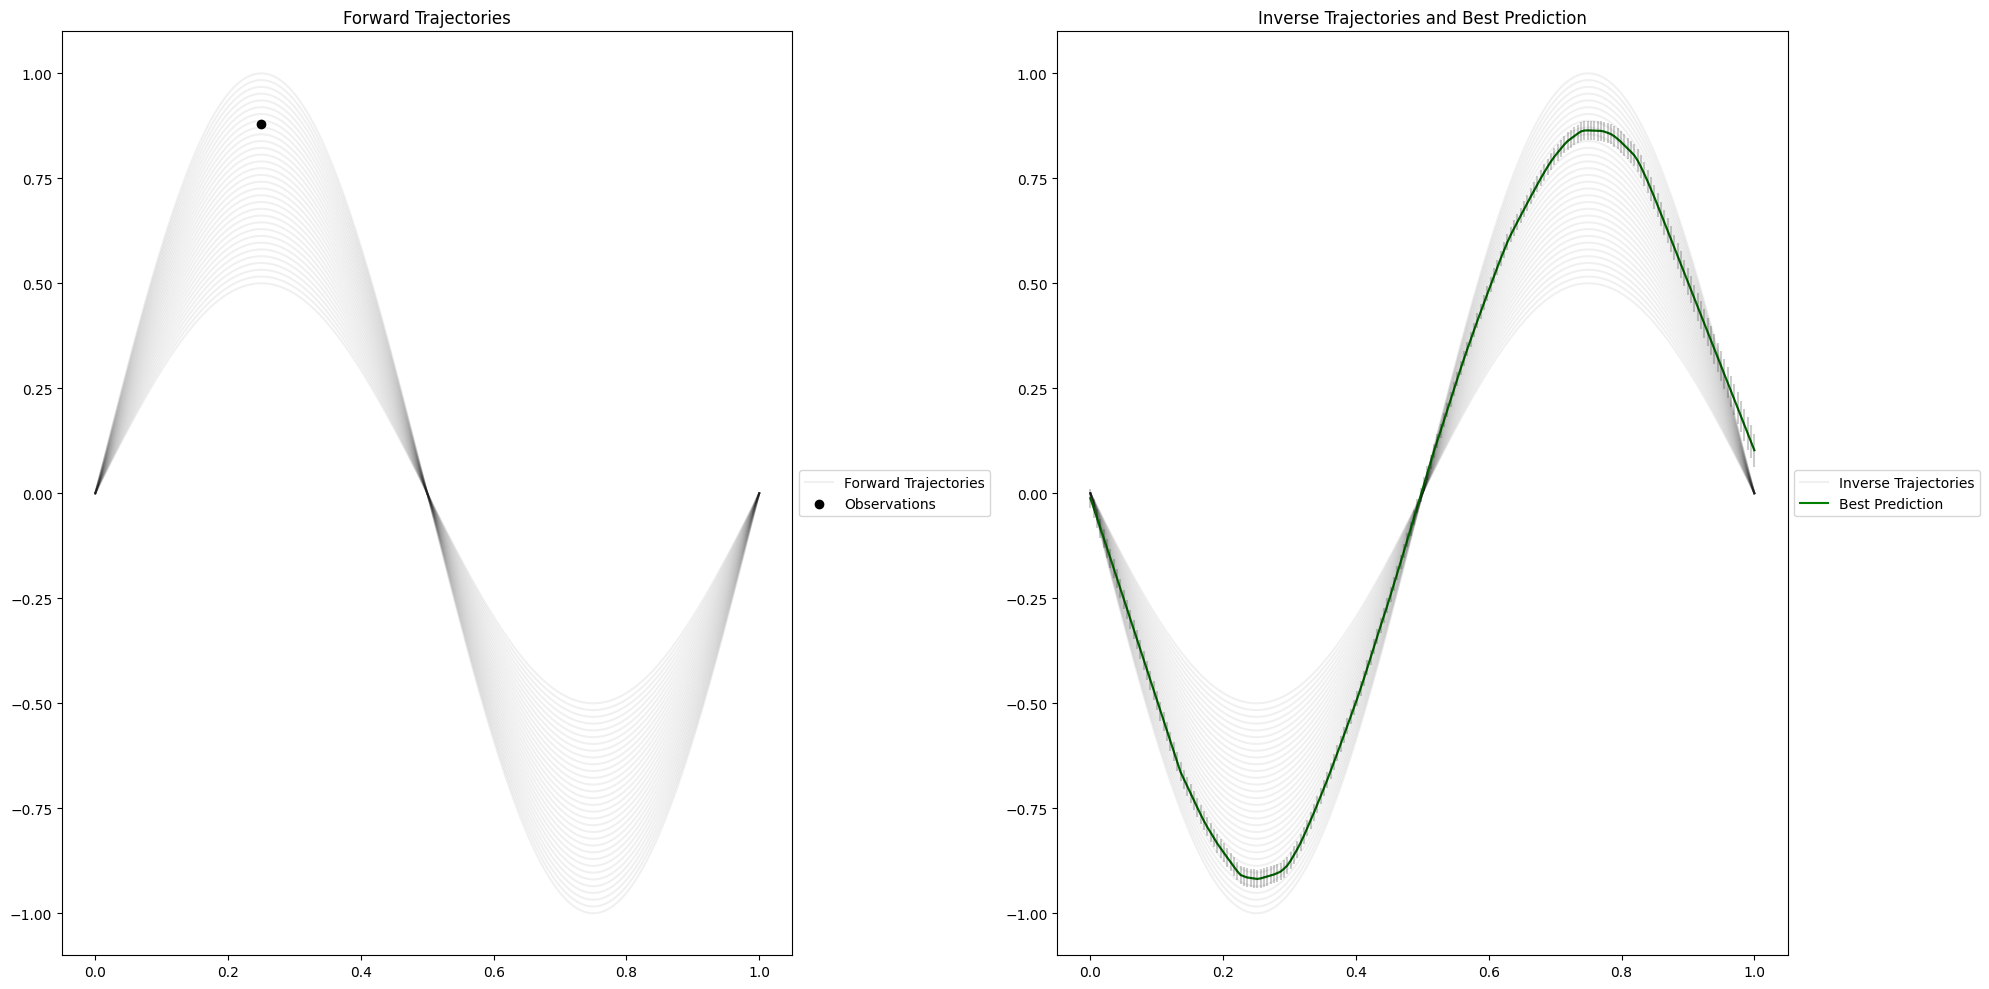

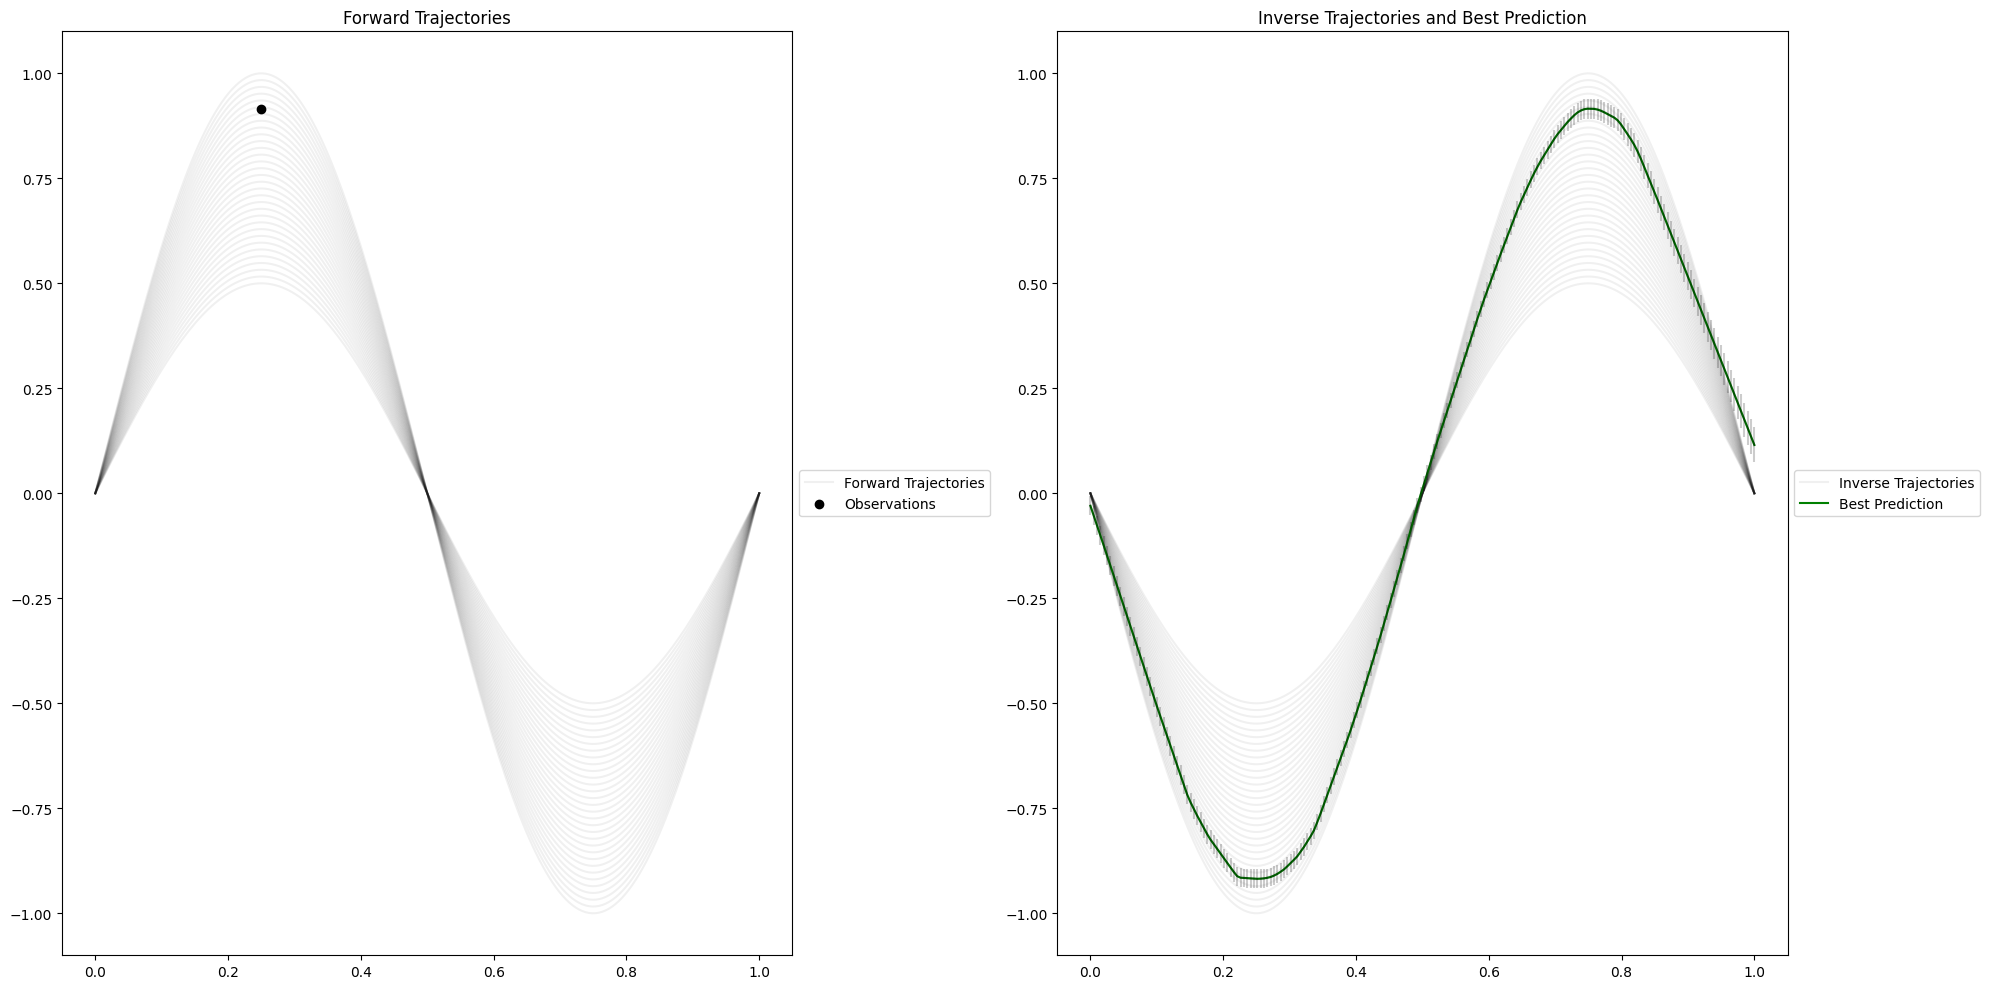

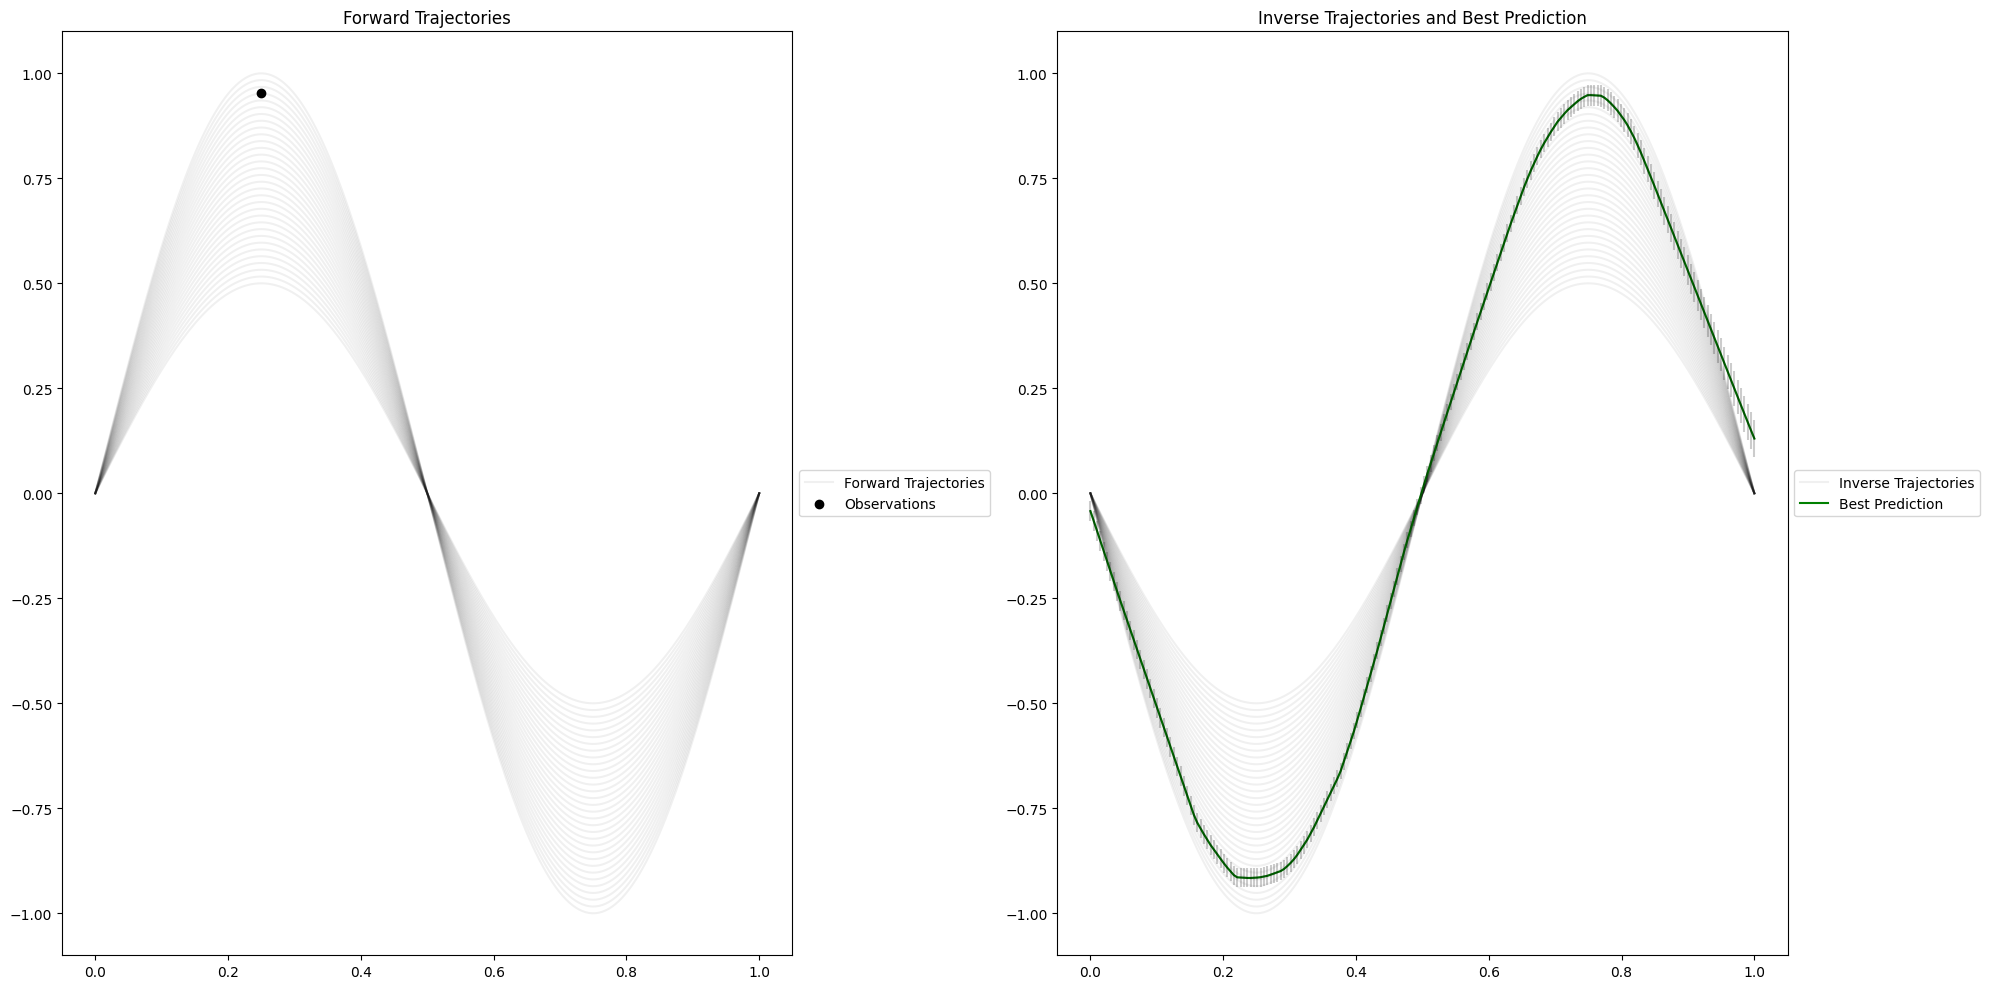

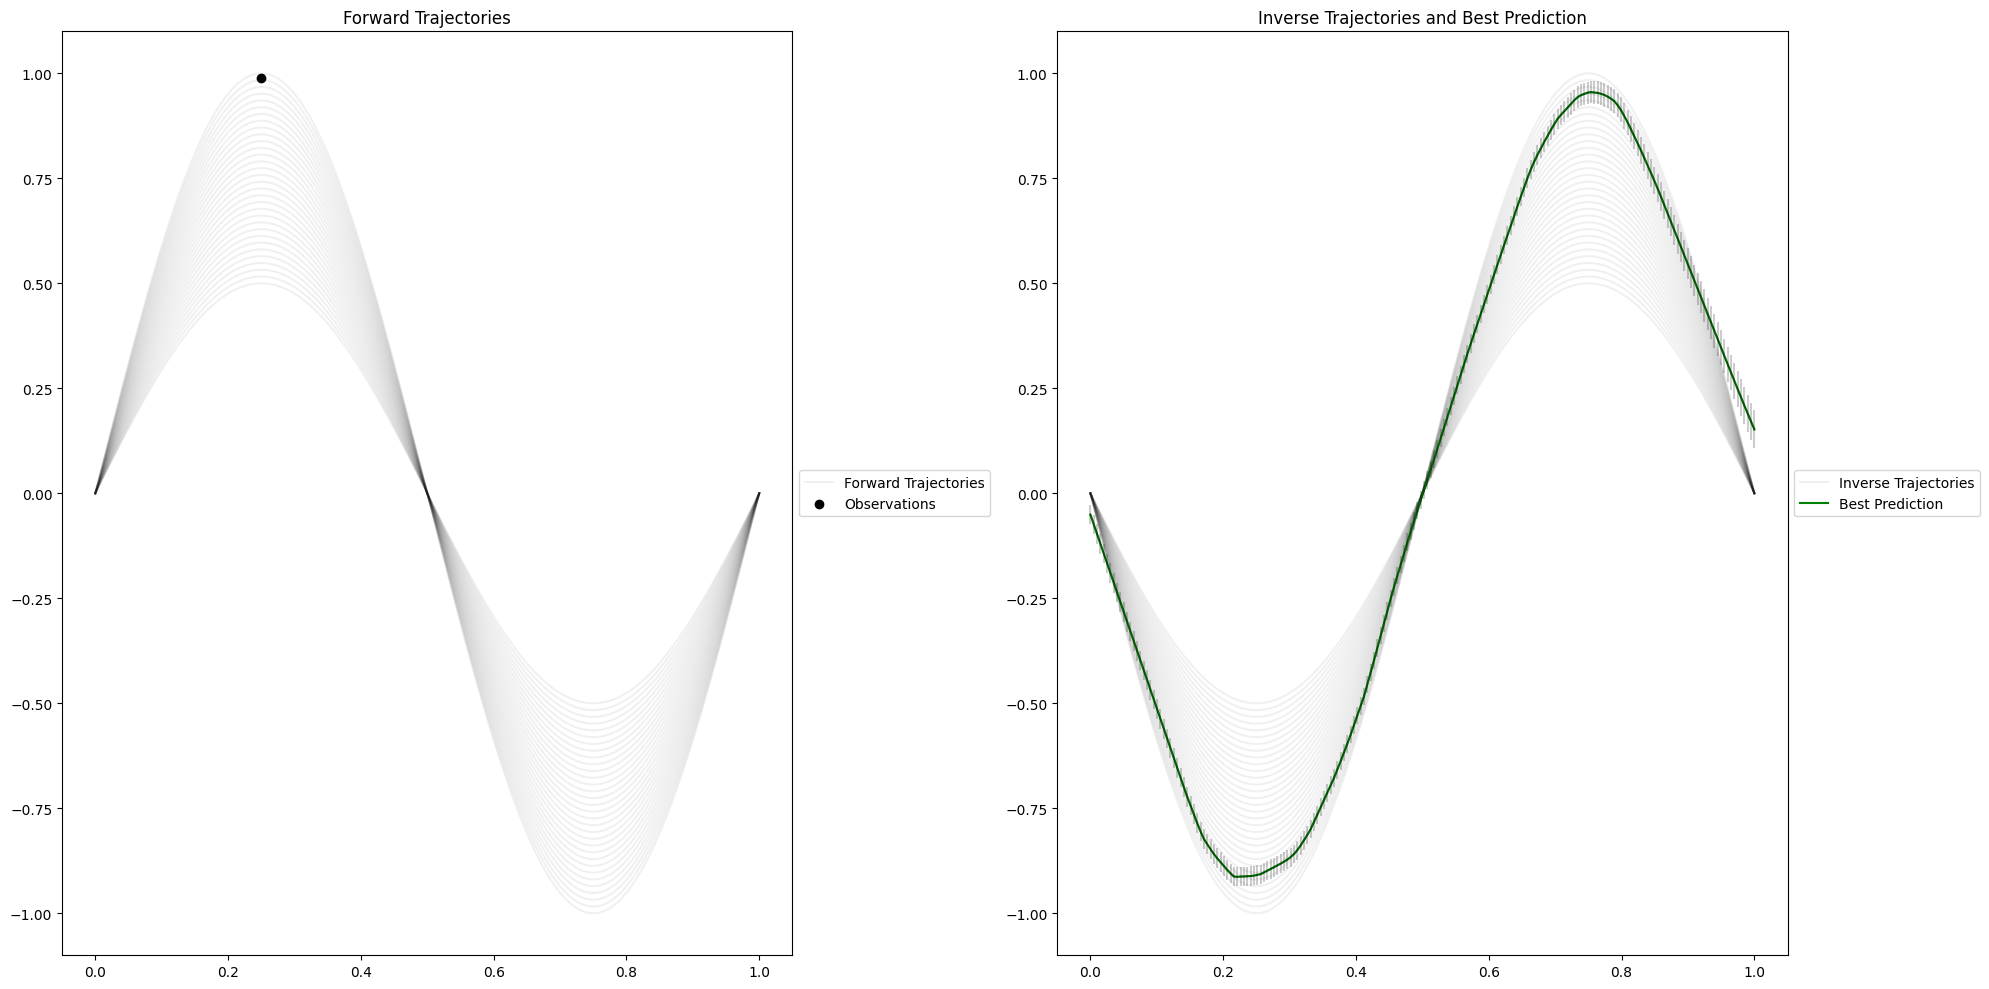

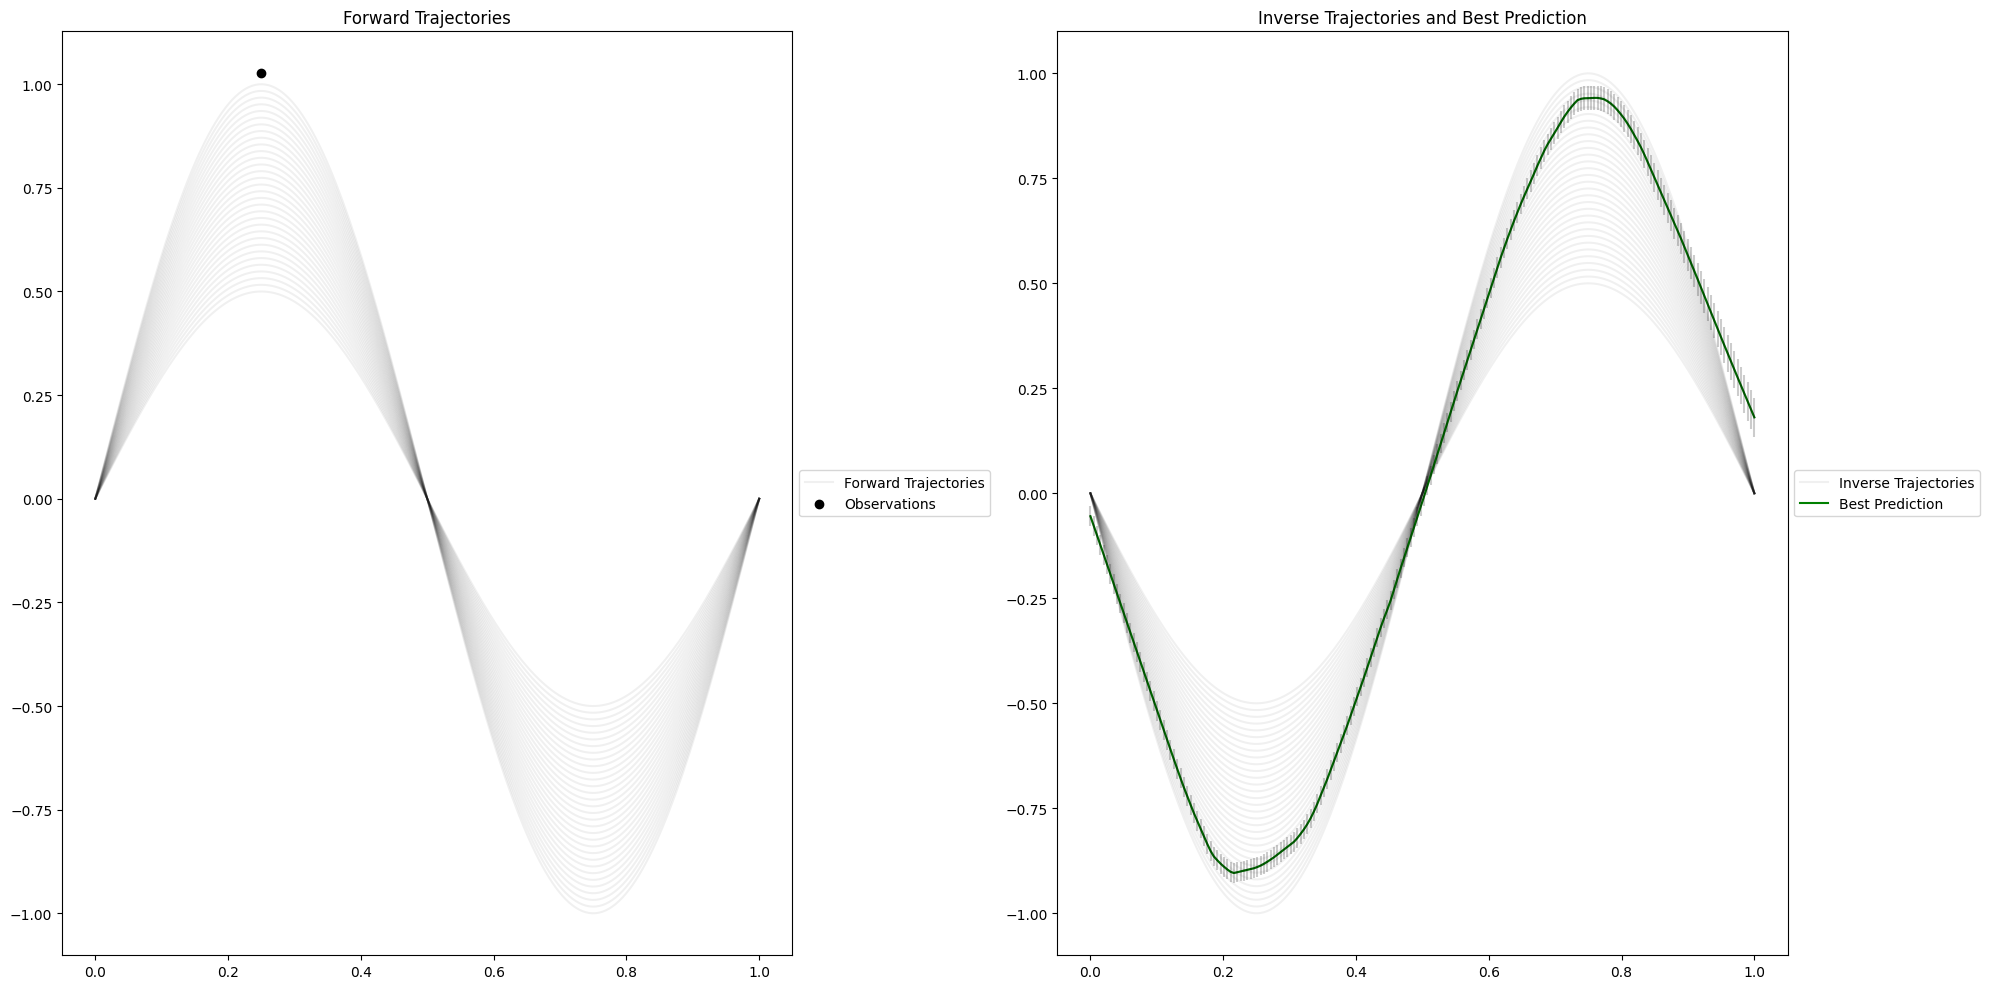

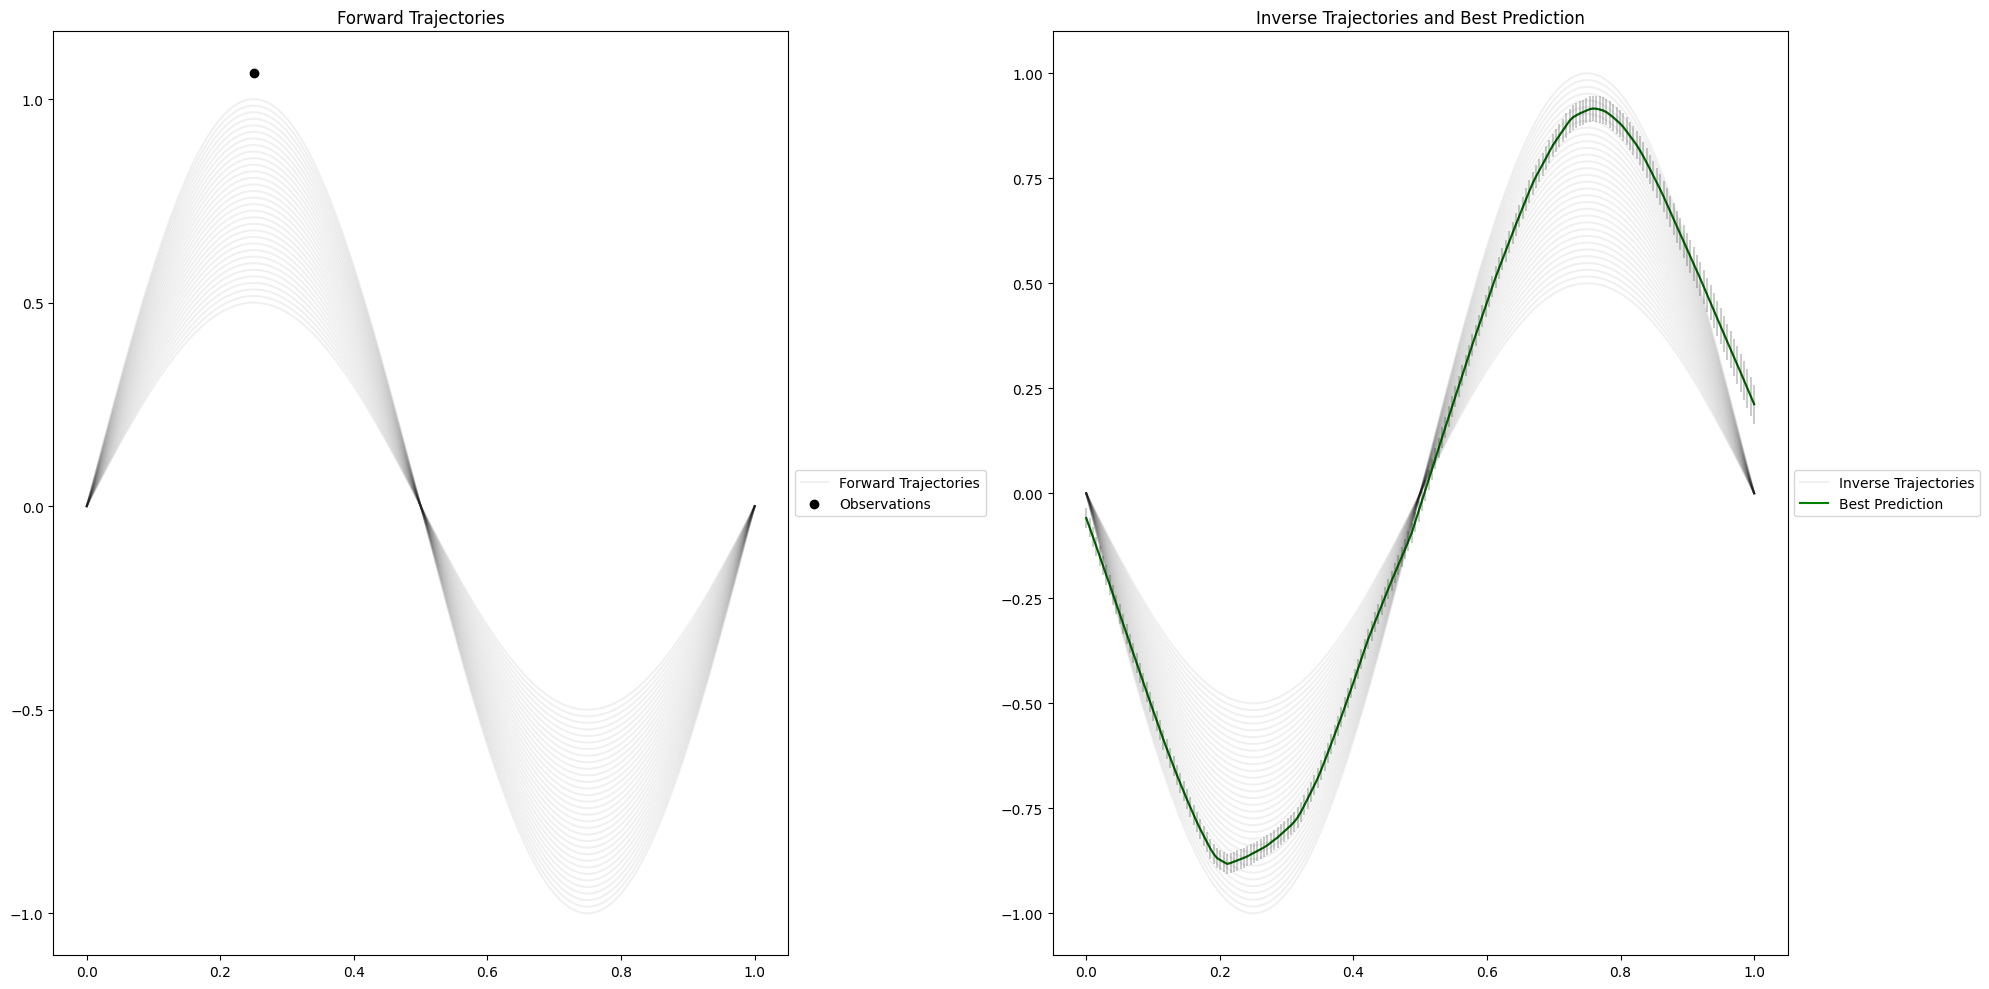

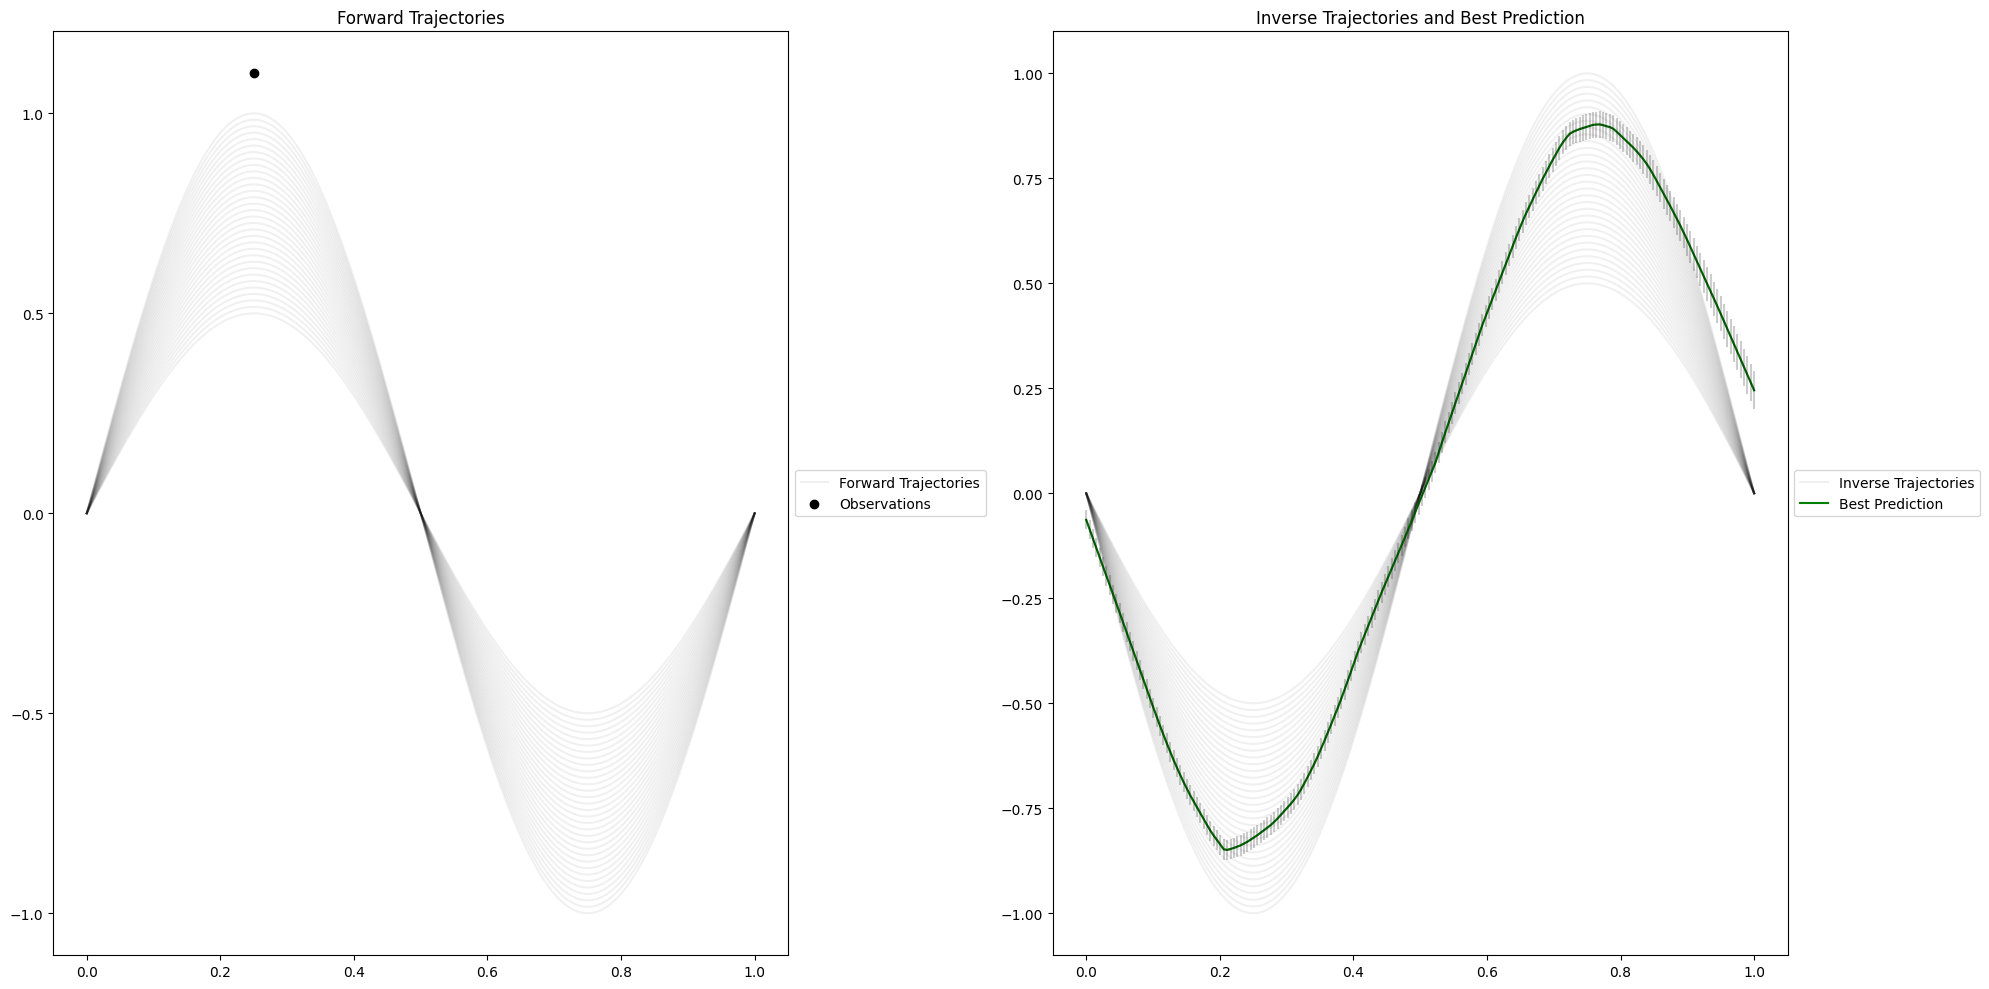

In [81]:
importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)

best_model = dual_enc_dec_cnmp.DualEncoderDecoder(d_x, d_y1, d_y2).double()
best_model.load_state_dict(torch.load('inverse_best_model.pth'))

t = 0.25
min_y = np.min(Y1[:, int(t * time_len)])
max_y = np.max(Y1[:, int(t * time_len)])
interval_y = np.linspace(min_y-0.1, max_y+0.1, 20)

i = 0
for idx in interval_y:
    condition_points = [[t, idx]]
    means, stds = dual_enc_dec_cnmp.predict_inverse(best_model, idx, time_len, condition_points, d_x, d_y1, d_y2, demo_data)
    if i == 0:
        utils.plot_results(means, stds, Y1, Y2, idx, condition_points, errors, losses, time_len, d_N, plot_errors = True)
        i += 1
    utils.plot_results(means, stds, Y1, Y2, idx, condition_points, errors, losses, time_len, d_N, plot_errors = False)